In [1]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import pandas as pd
import os
import pandas as pd
import json
import glob
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense
from sklearn.preprocessing import MinMaxScaler

### Load data

In [2]:
df = pd.read_csv('../../regioes/dadosFinais.csv', sep=';')
print(df.columns)
print(df['codLocation'].unique())

local = 1711115
df = df[df['codLocation'] == local]
df.head()

Index(['Avaliacoes Total', 'Avaliacoes Apartamentos', 'Avaliacoes Moradias',
       'Capital Divida Total', 'Capital Divida 3M', 'Capital Divida 6M',
       'Capital Divida 12M', 'Juros Totais', 'Capital Amortizado',
       'Unemployed population', 'Prestacao Media', 'Mês', 'Ano', 'mes', 'ano',
       '1 mês (Euribor)', '3 meses (Euribor)', '6 meses (Euribor)',
       '12 meses (Euribor)',
       'Número de beneficiários de subsídio de desemprego (milhares)-mensal',
       'Indicador coincidente para a atividade económica-Mensal-TVH',
       'Indicador coincidente para o consumo privado-Mensal-TVH',
       'Endividamento dos particulares-TVA', 'Endividamento dos particulares',
       'Endividamento dos particulares junto de empresas não financeiras',
       'Endividamento dos particulares junto do setor financeiro',
       'Endividamento dos particulares junto das administrações públicas',
       'Endividamento dos particulares junto de particulares',
       'Endividamento dos particul

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
1317,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180401,202955.666667,185891.371583,202.568216,0.0,3.0,1104.000000,993.847679,44.333333,7.0
1318,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180408,169080.000000,160455.685792,200.624071,9.0,-2.0,890.666667,833.423840,24.333333,3.0
1319,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180415,134624.333333,147097.842896,194.956268,-2.0,-2.0,675.333333,759.711920,1.000000,0.0
1320,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180422,134935.000000,141571.421448,205.506042,0.0,3.0,673.666667,710.855960,1.666667,0.0
1321,468,446,22.0,51817,97727,95476,94260.0,44,196,371.2,...,20180429,134707.000000,137953.710724,207.629057,0.0,-4.0,665.000000,678.927980,3.000000,0.0


In [3]:
# Separar variáveis independentes (X) e dependente (y)
X = df.drop(columns=['Preço médio_sell'])

# y = df[['Date','Preço médio_sell']]
y = df['Preço médio_sell'] # drop the m2

train_size = 0.7
test_size = 0.2
valid_size = 0.1

total_size = len(df)
train_end = int(train_size * total_size)
test_end = int((train_size + test_size) * total_size)

X_train = X.iloc[:train_end]
X_test = X.iloc[train_end:test_end]
X_valid = X.iloc[test_end:]

y_train = y.iloc[:train_end]
y_test = y.iloc[train_end:test_end]
y_valid = y.iloc[test_end:]


print(f"Tamanho do conjunto de treinamento: {len(X_train)}")
print(f"Tamanho do conjunto de teste: {len(X_test)}")
print(f"Tamanho do conjunto de validação: {len(X_valid)}")

# Preparar dados para treino
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_valid_scaled = scaler_X.transform(X_valid)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))
y_valid_scaled = scaler_y.transform(y_valid.values.reshape(-1, 1))


Tamanho do conjunto de treinamento: 231
Tamanho do conjunto de teste: 66
Tamanho do conjunto de validação: 34


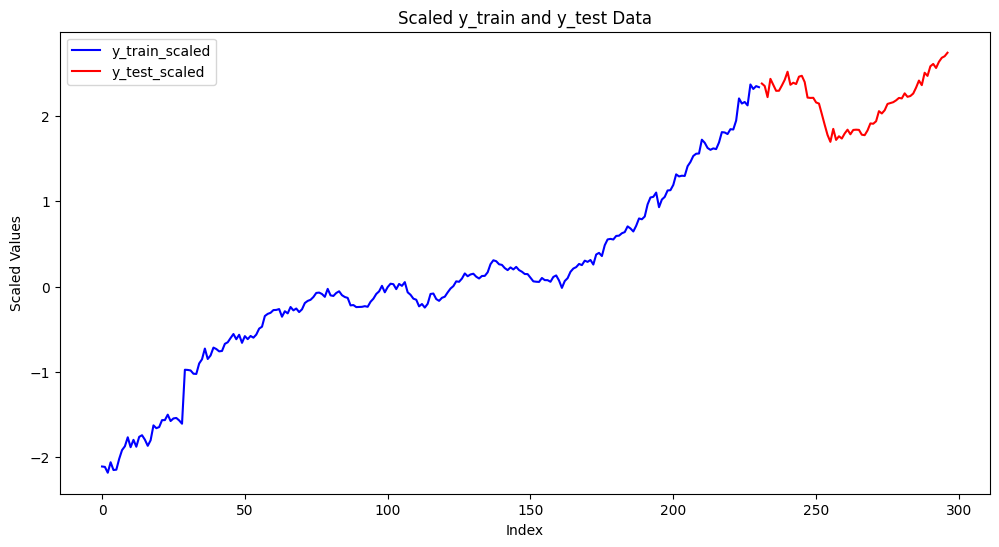

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_train_scaled, label='y_train_scaled', color='blue')
plt.plot(range(len(y_train_scaled), len(y_train_scaled) + len(y_test_scaled)), y_test_scaled, label='y_test_scaled', color='red')

plt.title('Scaled y_train and y_test Data')
plt.xlabel('Index')
plt.ylabel('Scaled Values')
plt.legend()
plt.show()

### Treino Dense neural network (MLP)

In [5]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import Huber
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

batch_size = 32
initial_learning_rate = 0.0009  # A learning rate inicial comum
steps_per_epoch = len(X_train_scaled) // batch_size  # Tamanho do batch (32) e tamanho do dataset
epochs = 650  # Total de épocas para treinamento
decay_steps = steps_per_epoch * 10  # Reduzir a learning rate após 10 épocas
decay_rate = 0.966  # Diminuir a learning rate em 5% a cada 10 épocas
activationF = 'tanh'  # Função de ativação comum

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
    staircase=True  # Usar degraus para ajustar a learning rate
)


model = Sequential()
model.add(Dense(192, activation=activationF, input_shape=(X_train.shape[1],),
                kernel_regularizer=regularizers.l2(0.006)))
model.add(BatchNormalization()) 
model.add(Dropout(0.25))

model.add(Dense(64, activation=activationF, kernel_regularizer=regularizers.l2(0.003)))
# model.add(Dense(64, activation='tanh'))
model.add(BatchNormalization()) 
model.add(Dense(batch_size, activation=activationF)) #, kernel_regularizer=regularizers.l2(0.003)))
model.add(Dense(1))



# # 3. Compilar o modelo
# initial_learning_rate = 0.001
# lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate,
#     decay_steps=100000,  # quantas etapas para o decaimento
#     decay_rate=0.96,     # taxa de decaimento
#     staircase=True       # se true, a learning rate diminui em "degraus"
# )

def r2_scoree(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    r2 = 1 - SS_res / (SS_tot + K.epsilon())
    return r2


# Compilar o modelo com a learning rate adaptativa
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
              loss=tf.keras.losses.Huber(), metrics=['mae', r2_scoree])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=100, 
                               restore_best_weights=True)

# 4. Treinar o modelo

history = model.fit(X_train_scaled, y_train_scaled, 
                    validation_data=(X_test_scaled, y_test_scaled), 
                    epochs=epochs, batch_size=batch_size,

                    callbacks=[early_stopping]
                    )


Epoch 1/650


c:\Users\ruben\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - loss: 1.3799 - mae: 0.8145 - r2_scoree: -0.0167

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 1.2742 - mae: 0.6870 - r2_scoree: 0.2099 - val_loss: 1.2400 - val_mae: 0.6311 - val_r2_scoree: -1976.2760


Epoch 2/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.1107 - mae: 0.4836 - r2_scoree: 0.6154

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0840 - mae: 0.4327 - r2_scoree: 0.6561 - val_loss: 1.2300 - val_mae: 0.6137 - val_r2_scoree: -2096.7551


Epoch 3/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 1.0188 - mae: 0.3302 - r2_scoree: 0.8289

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0367 - mae: 0.3811 - r2_scoree: 0.7586 - val_loss: 1.3796 - val_mae: 0.8504 - val_r2_scoree: -2921.8679


Epoch 4/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.0397 - mae: 0.4179 - r2_scoree: 0.7751

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0159 - mae: 0.3746 - r2_scoree: 0.7822 - val_loss: 1.3442 - val_mae: 0.8452 - val_r2_scoree: -2632.2781


Epoch 5/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.9529 - mae: 0.2669 - r2_scoree: 0.9054

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9643 - mae: 0.3007 - r2_scoree: 0.8517 - val_loss: 1.3677 - val_mae: 0.8903 - val_r2_scoree: -2706.1289


Epoch 6/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9419 - mae: 0.2856 - r2_scoree: 0.8743

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9386 - mae: 0.2830 - r2_scoree: 0.8764 - val_loss: 1.3406 - val_mae: 0.8738 - val_r2_scoree: -2680.5095


Epoch 7/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.9337 - mae: 0.3079 - r2_scoree: 0.7890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9198 - mae: 0.2695 - r2_scoree: 0.8609 - val_loss: 1.3667 - val_mae: 0.9304 - val_r2_scoree: -2871.5886


Epoch 8/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.8869 - mae: 0.2064 - r2_scoree: 0.9219

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8975 - mae: 0.2419 - r2_scoree: 0.8769 - val_loss: 1.4158 - val_mae: 1.0258 - val_r2_scoree: -2990.3816


Epoch 9/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8755 - mae: 0.2212 - r2_scoree: 0.9217

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8791 - mae: 0.2453 - r2_scoree: 0.8963 - val_loss: 1.4073 - val_mae: 1.0370 - val_r2_scoree: -3138.9373


Epoch 10/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8545 - mae: 0.2204 - r2_scoree: 0.9494

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8528 - mae: 0.2176 - r2_scoree: 0.9247 - val_loss: 1.3907 - val_mae: 1.0239 - val_r2_scoree: -3315.5515


Epoch 11/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.8215 - mae: 0.1517 - r2_scoree: 0.9593

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8339 - mae: 0.2044 - r2_scoree: 0.9246 - val_loss: 1.4690 - val_mae: 1.1380 - val_r2_scoree: -3632.7129


Epoch 12/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.8373 - mae: 0.2314 - r2_scoree: 0.8775

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8227 - mae: 0.2126 - r2_scoree: 0.8888 - val_loss: 1.5556 - val_mae: 1.2571 - val_r2_scoree: -3964.5125


Epoch 13/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.8199 - mae: 0.2468 - r2_scoree: 0.9210

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8060 - mae: 0.2149 - r2_scoree: 0.9259 - val_loss: 1.4910 - val_mae: 1.1995 - val_r2_scoree: -3819.4343


Epoch 14/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.8192 - mae: 0.2674 - r2_scoree: 0.8930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7976 - mae: 0.2341 - r2_scoree: 0.9051 - val_loss: 1.3877 - val_mae: 1.0721 - val_r2_scoree: -3832.7324


Epoch 15/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.7823 - mae: 0.2218 - r2_scoree: 0.8684

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7693 - mae: 0.2008 - r2_scoree: 0.9197 - val_loss: 1.4879 - val_mae: 1.2238 - val_r2_scoree: -4342.6470


Epoch 16/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.7542 - mae: 0.1869 - r2_scoree: 0.9252

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.7554 - mae: 0.1997 - r2_scoree: 0.9058 - val_loss: 1.5047 - val_mae: 1.2647 - val_r2_scoree: -4471.3105


Epoch 17/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.7447 - mae: 0.1995 - r2_scoree: 0.9416

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7360 - mae: 0.1921 - r2_scoree: 0.9344 - val_loss: 1.4997 - val_mae: 1.2665 - val_r2_scoree: -4617.5918


Epoch 18/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.7185 - mae: 0.1742 - r2_scoree: 0.9360

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.7121 - mae: 0.1661 - r2_scoree: 0.9489 - val_loss: 1.2820 - val_mae: 1.0308 - val_r2_scoree: -3587.7551


Epoch 19/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.6908 - mae: 0.1157 - r2_scoree: 0.9562

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7001 - mae: 0.1743 - r2_scoree: 0.9363 - val_loss: 1.2828 - val_mae: 1.0586 - val_r2_scoree: -3500.0325


Epoch 20/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.6828 - mae: 0.1538 - r2_scoree: 0.9716

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6906 - mae: 0.1897 - r2_scoree: 0.9266 - val_loss: 1.3557 - val_mae: 1.1716 - val_r2_scoree: -3867.7634


Epoch 21/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.6709 - mae: 0.1564 - r2_scoree: 0.9496

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6696 - mae: 0.1648 - r2_scoree: 0.9499 - val_loss: 1.3718 - val_mae: 1.1969 - val_r2_scoree: -4254.9375


Epoch 22/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.6626 - mae: 0.1657 - r2_scoree: 0.9434

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6605 - mae: 0.1800 - r2_scoree: 0.9414 - val_loss: 1.2979 - val_mae: 1.1186 - val_r2_scoree: -3909.6455


Epoch 23/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.6371 - mae: 0.1438 - r2_scoree: 0.9765

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6383 - mae: 0.1565 - r2_scoree: 0.9542 - val_loss: 1.3416 - val_mae: 1.1888 - val_r2_scoree: -3928.0781


Epoch 24/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6364 - mae: 0.1921 - r2_scoree: 0.9336

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6311 - mae: 0.1817 - r2_scoree: 0.9428 - val_loss: 1.3991 - val_mae: 1.2554 - val_r2_scoree: -4134.2856


Epoch 25/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.6310 - mae: 0.2236 - r2_scoree: 0.8888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.6235 - mae: 0.2016 - r2_scoree: 0.9215 - val_loss: 1.3723 - val_mae: 1.2342 - val_r2_scoree: -4110.5962


Epoch 26/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.5968 - mae: 0.1389 - r2_scoree: 0.9639

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.6009 - mae: 0.1625 - r2_scoree: 0.9530 - val_loss: 1.3665 - val_mae: 1.2570 - val_r2_scoree: -4059.7314


Epoch 27/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.5889 - mae: 0.1425 - r2_scoree: 0.9574

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5859 - mae: 0.1528 - r2_scoree: 0.9552 - val_loss: 1.4408 - val_mae: 1.3516 - val_r2_scoree: -4379.8696


Epoch 28/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.5853 - mae: 0.1789 - r2_scoree: 0.9206

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5767 - mae: 0.1692 - r2_scoree: 0.9423 - val_loss: 1.5323 - val_mae: 1.4652 - val_r2_scoree: -4391.6426


Epoch 29/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5579 - mae: 0.1447 - r2_scoree: 0.9735

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5596 - mae: 0.1609 - r2_scoree: 0.9541 - val_loss: 1.4832 - val_mae: 1.4236 - val_r2_scoree: -4187.2769


Epoch 30/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5565 - mae: 0.1714 - r2_scoree: 0.9274

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5518 - mae: 0.1675 - r2_scoree: 0.9451 - val_loss: 1.5517 - val_mae: 1.5120 - val_r2_scoree: -4682.0151


Epoch 31/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.5406 - mae: 0.1573 - r2_scoree: 0.9465

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5333 - mae: 0.1439 - r2_scoree: 0.9611 - val_loss: 1.6280 - val_mae: 1.6054 - val_r2_scoree: -5227.6777


Epoch 32/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5209 - mae: 0.1366 - r2_scoree: 0.9760

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5212 - mae: 0.1458 - r2_scoree: 0.9628 - val_loss: 1.5997 - val_mae: 1.5908 - val_r2_scoree: -5029.0811


Epoch 33/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.5050 - mae: 0.1127 - r2_scoree: 0.9847

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5048 - mae: 0.1266 - r2_scoree: 0.9742 - val_loss: 1.5028 - val_mae: 1.4943 - val_r2_scoree: -4802.9839


Epoch 34/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.5040 - mae: 0.1663 - r2_scoree: 0.9473

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4967 - mae: 0.1454 - r2_scoree: 0.9625 - val_loss: 1.4445 - val_mae: 1.4446 - val_r2_scoree: -4669.8833


Epoch 35/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4819 - mae: 0.1190 - r2_scoree: 0.9762

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4826 - mae: 0.1256 - r2_scoree: 0.9308 - val_loss: 1.4864 - val_mae: 1.4987 - val_r2_scoree: -5104.1445


Epoch 36/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.4765 - mae: 0.1384 - r2_scoree: 0.9684

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4710 - mae: 0.1301 - r2_scoree: 0.9712 - val_loss: 1.4296 - val_mae: 1.4476 - val_r2_scoree: -4986.2007


Epoch 37/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4638 - mae: 0.1253 - r2_scoree: 0.9689

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4631 - mae: 0.1337 - r2_scoree: 0.9622 - val_loss: 1.3820 - val_mae: 1.4015 - val_r2_scoree: -4972.9497


Epoch 38/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.4567 - mae: 0.1667 - r2_scoree: 0.9367

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4520 - mae: 0.1447 - r2_scoree: 0.9580 - val_loss: 1.3826 - val_mae: 1.4117 - val_r2_scoree: -5224.2378


Epoch 39/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.4425 - mae: 0.1342 - r2_scoree: 0.9730

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4391 - mae: 0.1286 - r2_scoree: 0.9734 - val_loss: 1.3515 - val_mae: 1.3911 - val_r2_scoree: -5041.3384


Epoch 40/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4343 - mae: 0.1383 - r2_scoree: 0.9631

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4281 - mae: 0.1249 - r2_scoree: 0.9718 - val_loss: 1.3513 - val_mae: 1.4010 - val_r2_scoree: -5091.2339


Epoch 41/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.4313 - mae: 0.1734 - r2_scoree: 0.9529

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4256 - mae: 0.1542 - r2_scoree: 0.9515 - val_loss: 1.3389 - val_mae: 1.3950 - val_r2_scoree: -5233.8462


Epoch 42/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.4048 - mae: 0.0877 - r2_scoree: 0.9884

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4066 - mae: 0.1110 - r2_scoree: 0.9740 - val_loss: 1.2352 - val_mae: 1.2968 - val_r2_scoree: -4813.6890


Epoch 43/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3976 - mae: 0.0956 - r2_scoree: 0.9858

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3991 - mae: 0.1213 - r2_scoree: 0.9729 - val_loss: 1.1799 - val_mae: 1.2490 - val_r2_scoree: -4524.1782


Epoch 44/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.3901 - mae: 0.1226 - r2_scoree: 0.9769

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3902 - mae: 0.1312 - r2_scoree: 0.9700 - val_loss: 1.2399 - val_mae: 1.3221 - val_r2_scoree: -4878.2065


Epoch 45/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.3788 - mae: 0.1121 - r2_scoree: 0.9813

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3797 - mae: 0.1231 - r2_scoree: 0.9747 - val_loss: 1.2896 - val_mae: 1.3873 - val_r2_scoree: -5239.6431


Epoch 46/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3838 - mae: 0.1662 - r2_scoree: 0.9117

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3766 - mae: 0.1453 - r2_scoree: 0.9515 - val_loss: 1.1653 - val_mae: 1.2558 - val_r2_scoree: -4833.8726


Epoch 47/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3627 - mae: 0.1088 - r2_scoree: 0.9687

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3604 - mae: 0.1103 - r2_scoree: 0.9763 - val_loss: 1.0670 - val_mae: 1.1539 - val_r2_scoree: -4330.6050


Epoch 48/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3581 - mae: 0.1284 - r2_scoree: 0.9706

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3542 - mae: 0.1192 - r2_scoree: 0.9734 - val_loss: 1.0951 - val_mae: 1.2000 - val_r2_scoree: -4475.3760


Epoch 49/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.3500 - mae: 0.1447 - r2_scoree: 0.9765

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3450 - mae: 0.1230 - r2_scoree: 0.9772 - val_loss: 1.1553 - val_mae: 1.2770 - val_r2_scoree: -4920.5181


Epoch 50/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3422 - mae: 0.1401 - r2_scoree: 0.9750

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3374 - mae: 0.1212 - r2_scoree: 0.9753 - val_loss: 1.1760 - val_mae: 1.3062 - val_r2_scoree: -5138.7231


Epoch 51/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.3272 - mae: 0.1006 - r2_scoree: 0.9854

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3289 - mae: 0.1204 - r2_scoree: 0.9761 - val_loss: 1.1915 - val_mae: 1.3300 - val_r2_scoree: -5318.6138


Epoch 52/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3214 - mae: 0.1141 - r2_scoree: 0.9831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3206 - mae: 0.1198 - r2_scoree: 0.9575 - val_loss: 1.1872 - val_mae: 1.3276 - val_r2_scoree: -5411.8804


Epoch 53/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3186 - mae: 0.1460 - r2_scoree: 0.9666

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3140 - mae: 0.1236 - r2_scoree: 0.9716 - val_loss: 1.1348 - val_mae: 1.2685 - val_r2_scoree: -5289.5435


Epoch 54/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.3068 - mae: 0.1221 - r2_scoree: 0.9830

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3075 - mae: 0.1272 - r2_scoree: 0.9713 - val_loss: 1.0816 - val_mae: 1.2024 - val_r2_scoree: -5390.6763


Epoch 55/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.3011 - mae: 0.1281 - r2_scoree: 0.9814

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2994 - mae: 0.1229 - r2_scoree: 0.9768 - val_loss: 0.9803 - val_mae: 1.0875 - val_r2_scoree: -5019.0151


Epoch 56/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2920 - mae: 0.1204 - r2_scoree: 0.9798

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2918 - mae: 0.1178 - r2_scoree: 0.9771 - val_loss: 1.0331 - val_mae: 1.1509 - val_r2_scoree: -5538.4585


Epoch 57/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.2857 - mae: 0.1114 - r2_scoree: 0.9750

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2845 - mae: 0.1119 - r2_scoree: 0.9776 - val_loss: 1.1527 - val_mae: 1.2929 - val_r2_scoree: -6225.4663


Epoch 58/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.2777 - mae: 0.1041 - r2_scoree: 0.9724

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2764 - mae: 0.1069 - r2_scoree: 0.9788 - val_loss: 1.4107 - val_mae: 1.5847 - val_r2_scoree: -7393.4409


Epoch 59/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2690 - mae: 0.0917 - r2_scoree: 0.9796

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2711 - mae: 0.1123 - r2_scoree: 0.9688 - val_loss: 1.4920 - val_mae: 1.6856 - val_r2_scoree: -7631.4243


Epoch 60/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2613 - mae: 0.0819 - r2_scoree: 0.9874

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2624 - mae: 0.0992 - r2_scoree: 0.9818 - val_loss: 1.5015 - val_mae: 1.7059 - val_r2_scoree: -7690.4321


Epoch 61/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2610 - mae: 0.1106 - r2_scoree: 0.9798

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2570 - mae: 0.1003 - r2_scoree: 0.9819 - val_loss: 1.2512 - val_mae: 1.4323 - val_r2_scoree: -6633.5854


Epoch 62/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.2649 - mae: 0.1592 - r2_scoree: 0.9318

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2564 - mae: 0.1317 - r2_scoree: 0.9620 - val_loss: 1.2041 - val_mae: 1.3856 - val_r2_scoree: -6562.1895


Epoch 63/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2421 - mae: 0.0786 - r2_scoree: 0.9897

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2431 - mae: 0.0936 - r2_scoree: 0.9845 - val_loss: 1.1496 - val_mae: 1.3319 - val_r2_scoree: -6188.8062


Epoch 64/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.2424 - mae: 0.1109 - r2_scoree: 0.9833

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2393 - mae: 0.0987 - r2_scoree: 0.9828 - val_loss: 1.1965 - val_mae: 1.3856 - val_r2_scoree: -6518.7876


Epoch 65/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2372 - mae: 0.1086 - r2_scoree: 0.9744

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2350 - mae: 0.1053 - r2_scoree: 0.9787 - val_loss: 1.2598 - val_mae: 1.4593 - val_r2_scoree: -6793.3120


Epoch 66/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.2244 - mae: 0.0673 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2277 - mae: 0.0996 - r2_scoree: 0.9762 - val_loss: 1.2984 - val_mae: 1.5068 - val_r2_scoree: -6929.4429


Epoch 67/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2308 - mae: 0.1249 - r2_scoree: 0.9773

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2254 - mae: 0.1120 - r2_scoree: 0.9753 - val_loss: 1.1748 - val_mae: 1.3816 - val_r2_scoree: -6065.1855


Epoch 68/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.2164 - mae: 0.0891 - r2_scoree: 0.9875

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2184 - mae: 0.1069 - r2_scoree: 0.9785 - val_loss: 1.3113 - val_mae: 1.5313 - val_r2_scoree: -6817.3647


Epoch 69/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2259 - mae: 0.1416 - r2_scoree: 0.9323

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2160 - mae: 0.1134 - r2_scoree: 0.9578 - val_loss: 1.3913 - val_mae: 1.6249 - val_r2_scoree: -6732.9038


Epoch 70/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.2086 - mae: 0.1093 - r2_scoree: 0.9728

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2085 - mae: 0.1110 - r2_scoree: 0.9765 - val_loss: 1.2783 - val_mae: 1.5104 - val_r2_scoree: -5879.0034


Epoch 71/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.2016 - mae: 0.0824 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2040 - mae: 0.1077 - r2_scoree: 0.9738 - val_loss: 1.3320 - val_mae: 1.5849 - val_r2_scoree: -5653.6919


Epoch 72/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.1990 - mae: 0.0951 - r2_scoree: 0.9815

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2024 - mae: 0.1182 - r2_scoree: 0.9709 - val_loss: 1.5913 - val_mae: 1.8791 - val_r2_scoree: -6490.8770


Epoch 73/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1956 - mae: 0.1069 - r2_scoree: 0.9824

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1951 - mae: 0.1108 - r2_scoree: 0.9795 - val_loss: 1.5509 - val_mae: 1.8377 - val_r2_scoree: -6299.3130


Epoch 74/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1968 - mae: 0.1225 - r2_scoree: 0.9729

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1922 - mae: 0.1068 - r2_scoree: 0.9769 - val_loss: 1.3904 - val_mae: 1.6499 - val_r2_scoree: -6050.3711


Epoch 75/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1835 - mae: 0.0852 - r2_scoree: 0.9871

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1857 - mae: 0.1034 - r2_scoree: 0.9767 - val_loss: 1.0489 - val_mae: 1.2709 - val_r2_scoree: -5150.1514


Epoch 76/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1909 - mae: 0.1333 - r2_scoree: 0.9613

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1867 - mae: 0.1191 - r2_scoree: 0.9710 - val_loss: 0.9109 - val_mae: 1.1083 - val_r2_scoree: -4869.4751


Epoch 77/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1808 - mae: 0.1060 - r2_scoree: 0.9615

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1813 - mae: 0.1165 - r2_scoree: 0.9667 - val_loss: 0.8763 - val_mae: 1.0729 - val_r2_scoree: -4824.6670


Epoch 78/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1718 - mae: 0.0871 - r2_scoree: 0.9858

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1746 - mae: 0.1035 - r2_scoree: 0.9769 - val_loss: 0.8488 - val_mae: 1.0461 - val_r2_scoree: -4594.1440


Epoch 79/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1724 - mae: 0.1080 - r2_scoree: 0.9792

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1716 - mae: 0.1097 - r2_scoree: 0.9749 - val_loss: 0.9808 - val_mae: 1.2058 - val_r2_scoree: -4954.7334


Epoch 80/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1640 - mae: 0.0803 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1672 - mae: 0.1047 - r2_scoree: 0.9774 - val_loss: 1.1808 - val_mae: 1.4513 - val_r2_scoree: -5652.4355


Epoch 81/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1622 - mae: 0.0841 - r2_scoree: 0.9852

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1629 - mae: 0.0977 - r2_scoree: 0.9753 - val_loss: 1.0928 - val_mae: 1.3692 - val_r2_scoree: -5299.7041


Epoch 82/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1660 - mae: 0.1377 - r2_scoree: 0.9711

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1622 - mae: 0.1154 - r2_scoree: 0.9759 - val_loss: 1.0344 - val_mae: 1.3052 - val_r2_scoree: -5162.9258


Epoch 83/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1605 - mae: 0.1124 - r2_scoree: 0.9780

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1580 - mae: 0.1051 - r2_scoree: 0.9800 - val_loss: 0.9696 - val_mae: 1.2274 - val_r2_scoree: -5135.5835


Epoch 84/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1506 - mae: 0.0783 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1542 - mae: 0.1057 - r2_scoree: 0.9797 - val_loss: 0.9297 - val_mae: 1.1857 - val_r2_scoree: -4995.6738


Epoch 85/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.1508 - mae: 0.1025 - r2_scoree: 0.9809

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1501 - mae: 0.0995 - r2_scoree: 0.9804 - val_loss: 0.8226 - val_mae: 1.0883 - val_r2_scoree: -4493.3608


Epoch 86/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.1454 - mae: 0.0886 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1462 - mae: 0.0925 - r2_scoree: 0.9739 - val_loss: 0.8721 - val_mae: 1.1433 - val_r2_scoree: -4808.2983


Epoch 87/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1475 - mae: 0.1079 - r2_scoree: 0.9806

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1465 - mae: 0.1084 - r2_scoree: 0.9780 - val_loss: 0.8350 - val_mae: 1.0948 - val_r2_scoree: -4668.3936


Epoch 88/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.1382 - mae: 0.0697 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1415 - mae: 0.0986 - r2_scoree: 0.9801 - val_loss: 0.8909 - val_mae: 1.1349 - val_r2_scoree: -5147.0498


Epoch 89/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1441 - mae: 0.1379 - r2_scoree: 0.9784

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1429 - mae: 0.1265 - r2_scoree: 0.9661 - val_loss: 0.8655 - val_mae: 1.0906 - val_r2_scoree: -5295.4604


Epoch 90/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1550 - mae: 0.1792 - r2_scoree: 0.9549

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1453 - mae: 0.1409 - r2_scoree: 0.9620 - val_loss: 0.6952 - val_mae: 0.8929 - val_r2_scoree: -4154.6616


Epoch 91/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1345 - mae: 0.1079 - r2_scoree: 0.9770

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1342 - mae: 0.1064 - r2_scoree: 0.9802 - val_loss: 0.8557 - val_mae: 1.0594 - val_r2_scoree: -4982.8320


Epoch 92/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.1321 - mae: 0.1073 - r2_scoree: 0.9831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1318 - mae: 0.1047 - r2_scoree: 0.9773 - val_loss: 0.8252 - val_mae: 1.0181 - val_r2_scoree: -4728.5576


Epoch 93/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1418 - mae: 0.1659 - r2_scoree: 0.9392

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1329 - mae: 0.1248 - r2_scoree: 0.9676 - val_loss: 0.8752 - val_mae: 1.0891 - val_r2_scoree: -5171.9448


Epoch 94/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1251 - mae: 0.0847 - r2_scoree: 0.9836

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1270 - mae: 0.1040 - r2_scoree: 0.9783 - val_loss: 1.0423 - val_mae: 1.3118 - val_r2_scoree: -5646.2852


Epoch 95/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1201 - mae: 0.0746 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1230 - mae: 0.0951 - r2_scoree: 0.9800 - val_loss: 0.9296 - val_mae: 1.1696 - val_r2_scoree: -5268.3062


Epoch 96/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.1218 - mae: 0.1033 - r2_scoree: 0.9802

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1211 - mae: 0.1040 - r2_scoree: 0.9804 - val_loss: 1.0951 - val_mae: 1.3656 - val_r2_scoree: -6036.7363


Epoch 97/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.1176 - mae: 0.0889 - r2_scoree: 0.9816

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1194 - mae: 0.1027 - r2_scoree: 0.9776 - val_loss: 1.0353 - val_mae: 1.2959 - val_r2_scoree: -6090.6738


Epoch 98/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1168 - mae: 0.0998 - r2_scoree: 0.9820

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1182 - mae: 0.1081 - r2_scoree: 0.9752 - val_loss: 0.9477 - val_mae: 1.1750 - val_r2_scoree: -5972.4805


Epoch 99/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1150 - mae: 0.1055 - r2_scoree: 0.9761

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1168 - mae: 0.1162 - r2_scoree: 0.9729 - val_loss: 1.0294 - val_mae: 1.2665 - val_r2_scoree: -6277.1724


Epoch 100/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.1135 - mae: 0.1113 - r2_scoree: 0.9806

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1112 - mae: 0.0970 - r2_scoree: 0.9844 - val_loss: 0.9871 - val_mae: 1.2112 - val_r2_scoree: -5992.2300


Epoch 101/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1228 - mae: 0.1447 - r2_scoree: 0.9373

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1150 - mae: 0.1181 - r2_scoree: 0.9635 - val_loss: 1.0818 - val_mae: 1.3284 - val_r2_scoree: -6331.8652


Epoch 102/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1096 - mae: 0.1046 - r2_scoree: 0.9778

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1081 - mae: 0.1005 - r2_scoree: 0.9815 - val_loss: 1.0495 - val_mae: 1.2979 - val_r2_scoree: -6068.9897


Epoch 103/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1041 - mae: 0.0895 - r2_scoree: 0.9891

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1039 - mae: 0.0879 - r2_scoree: 0.9873 - val_loss: 1.0453 - val_mae: 1.2936 - val_r2_scoree: -6015.1875


Epoch 104/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1049 - mae: 0.1087 - r2_scoree: 0.9893

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1033 - mae: 0.0988 - r2_scoree: 0.9844 - val_loss: 1.1418 - val_mae: 1.4021 - val_r2_scoree: -6577.9458


Epoch 105/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1001 - mae: 0.0909 - r2_scoree: 0.9802

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1005 - mae: 0.0951 - r2_scoree: 0.9800 - val_loss: 1.1907 - val_mae: 1.4716 - val_r2_scoree: -6768.2437


Epoch 106/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0976 - mae: 0.0859 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0984 - mae: 0.0895 - r2_scoree: 0.9860 - val_loss: 1.2116 - val_mae: 1.5026 - val_r2_scoree: -6991.8521


Epoch 107/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0963 - mae: 0.0791 - r2_scoree: 0.9861

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0955 - mae: 0.0790 - r2_scoree: 0.9865 - val_loss: 1.2627 - val_mae: 1.5611 - val_r2_scoree: -7544.5469


Epoch 108/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0916 - mae: 0.0706 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0943 - mae: 0.0879 - r2_scoree: 0.9866 - val_loss: 1.2614 - val_mae: 1.5609 - val_r2_scoree: -7710.0972


Epoch 109/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0933 - mae: 0.0884 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0935 - mae: 0.0939 - r2_scoree: 0.9810 - val_loss: 1.1102 - val_mae: 1.3892 - val_r2_scoree: -6793.8638


Epoch 110/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0899 - mae: 0.0781 - r2_scoree: 0.9892

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0909 - mae: 0.0879 - r2_scoree: 0.9849 - val_loss: 0.9848 - val_mae: 1.2423 - val_r2_scoree: -6120.7349


Epoch 111/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0903 - mae: 0.0997 - r2_scoree: 0.9851

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0902 - mae: 0.0971 - r2_scoree: 0.9829 - val_loss: 1.0168 - val_mae: 1.2973 - val_r2_scoree: -6346.6113


Epoch 112/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0853 - mae: 0.0753 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0928 - mae: 0.1152 - r2_scoree: 0.9660 - val_loss: 1.0612 - val_mae: 1.3643 - val_r2_scoree: -6035.2261


Epoch 113/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0834 - mae: 0.0714 - r2_scoree: 0.9913

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0839 - mae: 0.0776 - r2_scoree: 0.9892 - val_loss: 1.1003 - val_mae: 1.4182 - val_r2_scoree: -5909.2651


Epoch 114/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0867 - mae: 0.1044 - r2_scoree: 0.9804

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0862 - mae: 0.0938 - r2_scoree: 0.9790 - val_loss: 1.0860 - val_mae: 1.4110 - val_r2_scoree: -5935.7632


Epoch 115/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0824 - mae: 0.0926 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0841 - mae: 0.0914 - r2_scoree: 0.9613 - val_loss: 1.2112 - val_mae: 1.5772 - val_r2_scoree: -6521.4067


Epoch 116/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0791 - mae: 0.0699 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0809 - mae: 0.0866 - r2_scoree: 0.9838 - val_loss: 1.4485 - val_mae: 1.8342 - val_r2_scoree: -7252.0688


Epoch 117/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0806 - mae: 0.0914 - r2_scoree: 0.9790

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0830 - mae: 0.0986 - r2_scoree: 0.9790 - val_loss: 1.6276 - val_mae: 2.0260 - val_r2_scoree: -7787.6938


Epoch 118/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0839 - mae: 0.1209 - r2_scoree: 0.9796

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0815 - mae: 0.1047 - r2_scoree: 0.9743 - val_loss: 1.7162 - val_mae: 2.1239 - val_r2_scoree: -7943.5464


Epoch 119/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0798 - mae: 0.1074 - r2_scoree: 0.9852

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0777 - mae: 0.0889 - r2_scoree: 0.9866 - val_loss: 1.5210 - val_mae: 1.9256 - val_r2_scoree: -7472.6128


Epoch 120/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0796 - mae: 0.1053 - r2_scoree: 0.9789

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0776 - mae: 0.0962 - r2_scoree: 0.9830 - val_loss: 1.2960 - val_mae: 1.6860 - val_r2_scoree: -7079.5044


Epoch 121/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0769 - mae: 0.1026 - r2_scoree: 0.9808

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0772 - mae: 0.1049 - r2_scoree: 0.9798 - val_loss: 1.1616 - val_mae: 1.5534 - val_r2_scoree: -6439.7637


Epoch 122/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0736 - mae: 0.0911 - r2_scoree: 0.9836

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0750 - mae: 0.0972 - r2_scoree: 0.9813 - val_loss: 1.0861 - val_mae: 1.4574 - val_r2_scoree: -6436.0820


Epoch 123/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0711 - mae: 0.0885 - r2_scoree: 0.9886

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0720 - mae: 0.0890 - r2_scoree: 0.9851 - val_loss: 1.1756 - val_mae: 1.5411 - val_r2_scoree: -6976.4414


Epoch 124/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0685 - mae: 0.0759 - r2_scoree: 0.9877

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0716 - mae: 0.0939 - r2_scoree: 0.9827 - val_loss: 1.3608 - val_mae: 1.7478 - val_r2_scoree: -7718.0464


Epoch 125/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0686 - mae: 0.0808 - r2_scoree: 0.9816

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0708 - mae: 0.0935 - r2_scoree: 0.9826 - val_loss: 1.4185 - val_mae: 1.8473 - val_r2_scoree: -6716.0845


Epoch 126/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0745 - mae: 0.0971 - r2_scoree: 0.9844

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0710 - mae: 0.0953 - r2_scoree: 0.9710 - val_loss: 0.4153 - val_mae: 0.6465 - val_r2_scoree: -3088.8030


Epoch 127/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0662 - mae: 0.0852 - r2_scoree: 0.9835

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0666 - mae: 0.0852 - r2_scoree: 0.9859 - val_loss: 0.2016 - val_mae: 0.4158 - val_r2_scoree: -1154.4537


Epoch 128/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0665 - mae: 0.0981 - r2_scoree: 0.9832

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0666 - mae: 0.0924 - r2_scoree: 0.9778 - val_loss: 0.1765 - val_mae: 0.3886 - val_r2_scoree: -878.5428


Epoch 129/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0624 - mae: 0.0664 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0639 - mae: 0.0801 - r2_scoree: 0.9888 - val_loss: 0.1854 - val_mae: 0.3972 - val_r2_scoree: -982.7409


Epoch 130/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0638 - mae: 0.0836 - r2_scoree: 0.9897

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0666 - mae: 0.0996 - r2_scoree: 0.9806 - val_loss: 0.2673 - val_mae: 0.4836 - val_r2_scoree: -1756.4037


Epoch 131/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0645 - mae: 0.1009 - r2_scoree: 0.9849

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0675 - mae: 0.1159 - r2_scoree: 0.9752 - val_loss: 0.4082 - val_mae: 0.6545 - val_r2_scoree: -2923.0186


Epoch 132/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0655 - mae: 0.1060 - r2_scoree: 0.9722

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0641 - mae: 0.1003 - r2_scoree: 0.9806 - val_loss: 0.1716 - val_mae: 0.4080 - val_r2_scoree: -678.2364


Epoch 133/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0638 - mae: 0.1005 - r2_scoree: 0.9807

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0637 - mae: 0.0983 - r2_scoree: 0.9797 - val_loss: 0.1877 - val_mae: 0.4404 - val_r2_scoree: -729.7446


Epoch 134/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0598 - mae: 0.0842 - r2_scoree: 0.9864

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0614 - mae: 0.0904 - r2_scoree: 0.9793 - val_loss: 0.1970 - val_mae: 0.4674 - val_r2_scoree: -675.3200


Epoch 135/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0619 - mae: 0.0975 - r2_scoree: 0.9866

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0608 - mae: 0.0926 - r2_scoree: 0.9836 - val_loss: 0.1549 - val_mae: 0.3757 - val_r2_scoree: -651.8511


Epoch 136/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0638 - mae: 0.1116 - r2_scoree: 0.9820

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0640 - mae: 0.1142 - r2_scoree: 0.9772 - val_loss: 0.1843 - val_mae: 0.4290 - val_r2_scoree: -948.1228


Epoch 137/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0601 - mae: 0.0923 - r2_scoree: 0.9795

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0607 - mae: 0.1024 - r2_scoree: 0.9822 - val_loss: 0.2646 - val_mae: 0.5208 - val_r2_scoree: -1491.2125


Epoch 138/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0640 - mae: 0.1224 - r2_scoree: 0.9800

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0603 - mae: 0.1004 - r2_scoree: 0.9829 - val_loss: 0.2371 - val_mae: 0.4805 - val_r2_scoree: -1411.6371


Epoch 139/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0551 - mae: 0.0764 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0572 - mae: 0.0878 - r2_scoree: 0.9859 - val_loss: 0.1751 - val_mae: 0.3930 - val_r2_scoree: -1031.2740


Epoch 140/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0570 - mae: 0.0833 - r2_scoree: 0.9835

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0564 - mae: 0.0838 - r2_scoree: 0.9854 - val_loss: 0.1280 - val_mae: 0.3173 - val_r2_scoree: -664.3387


Epoch 141/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0578 - mae: 0.1067 - r2_scoree: 0.9847

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0561 - mae: 0.0891 - r2_scoree: 0.9844 - val_loss: 0.1352 - val_mae: 0.3213 - val_r2_scoree: -718.5659


Epoch 142/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0524 - mae: 0.0732 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0533 - mae: 0.0805 - r2_scoree: 0.9889 - val_loss: 0.1427 - val_mae: 0.3274 - val_r2_scoree: -771.2050


Epoch 143/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0526 - mae: 0.0813 - r2_scoree: 0.9870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0523 - mae: 0.0781 - r2_scoree: 0.9650 - val_loss: 0.1825 - val_mae: 0.3695 - val_r2_scoree: -1025.1938


Epoch 144/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0521 - mae: 0.0802 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0533 - mae: 0.0823 - r2_scoree: 0.9732 - val_loss: 0.1364 - val_mae: 0.3380 - val_r2_scoree: -709.1264


Epoch 145/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0523 - mae: 0.0901 - r2_scoree: 0.9826

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0528 - mae: 0.0911 - r2_scoree: 0.9835 - val_loss: 0.0945 - val_mae: 0.2592 - val_r2_scoree: -312.0494


Epoch 146/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0507 - mae: 0.0844 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0510 - mae: 0.0844 - r2_scoree: 0.9861 - val_loss: 0.0946 - val_mae: 0.2545 - val_r2_scoree: -279.5263


Epoch 147/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0496 - mae: 0.0785 - r2_scoree: 0.9918

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0511 - mae: 0.0882 - r2_scoree: 0.9856 - val_loss: 0.1058 - val_mae: 0.2837 - val_r2_scoree: -286.6019


Epoch 148/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0484 - mae: 0.0854 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0492 - mae: 0.0819 - r2_scoree: 0.9892 - val_loss: 0.0991 - val_mae: 0.2719 - val_r2_scoree: -383.8040


Epoch 149/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0516 - mae: 0.1009 - r2_scoree: 0.9817

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0505 - mae: 0.0970 - r2_scoree: 0.9837 - val_loss: 0.1105 - val_mae: 0.2938 - val_r2_scoree: -527.5735


Epoch 150/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0472 - mae: 0.0784 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0487 - mae: 0.0856 - r2_scoree: 0.9613 - val_loss: 0.1184 - val_mae: 0.3031 - val_r2_scoree: -590.9196


Epoch 151/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0475 - mae: 0.0815 - r2_scoree: 0.9867

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0495 - mae: 0.0907 - r2_scoree: 0.9841 - val_loss: 0.1086 - val_mae: 0.2701 - val_r2_scoree: -528.9881


Epoch 152/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0453 - mae: 0.0706 - r2_scoree: 0.9869

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0471 - mae: 0.0866 - r2_scoree: 0.9861 - val_loss: 0.1847 - val_mae: 0.3865 - val_r2_scoree: -946.9612


Epoch 153/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 0.0447 - mae: 0.0680 - r2_scoree: 0.9914

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0462 - mae: 0.0823 - r2_scoree: 0.9851 - val_loss: 0.5744 - val_mae: 0.9181 - val_r2_scoree: -2643.7683


Epoch 154/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0458 - mae: 0.0814 - r2_scoree: 0.9918

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470 - mae: 0.0884 - r2_scoree: 0.9865 - val_loss: 0.4764 - val_mae: 0.7841 - val_r2_scoree: -2292.6536


Epoch 155/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0444 - mae: 0.0781 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - mae: 0.0723 - r2_scoree: 0.9911 - val_loss: 0.4101 - val_mae: 0.6863 - val_r2_scoree: -2084.6384


Epoch 156/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0491 - mae: 0.0918 - r2_scoree: 0.9826

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0456 - mae: 0.0804 - r2_scoree: 0.9839 - val_loss: 0.2388 - val_mae: 0.4671 - val_r2_scoree: -1317.6583


Epoch 157/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0420 - mae: 0.0651 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0437 - mae: 0.0807 - r2_scoree: 0.9873 - val_loss: 0.6342 - val_mae: 0.9781 - val_r2_scoree: -3104.4895


Epoch 158/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0860 - mae: 0.1748 - r2_scoree: 0.8349

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0594 - mae: 0.1236 - r2_scoree: 0.9311 - val_loss: 0.2581 - val_mae: 0.5191 - val_r2_scoree: -1534.5092


Epoch 159/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0436 - mae: 0.0814 - r2_scoree: 0.9870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0464 - mae: 0.0985 - r2_scoree: 0.9546 - val_loss: 0.6586 - val_mae: 0.9852 - val_r2_scoree: -3924.7986


Epoch 160/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0445 - mae: 0.0988 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0441 - mae: 0.0922 - r2_scoree: 0.9838 - val_loss: 0.8721 - val_mae: 1.2545 - val_r2_scoree: -4568.6821


Epoch 161/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0416 - mae: 0.0675 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0444 - mae: 0.0907 - r2_scoree: 0.9844 - val_loss: 0.9611 - val_mae: 1.3582 - val_r2_scoree: -4690.9243


Epoch 162/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0403 - mae: 0.0664 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0426 - mae: 0.0817 - r2_scoree: 0.9764 - val_loss: 1.0536 - val_mae: 1.4563 - val_r2_scoree: -5135.0381


Epoch 163/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0425 - mae: 0.0895 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0470 - mae: 0.1019 - r2_scoree: 0.9680 - val_loss: 0.4989 - val_mae: 0.7816 - val_r2_scoree: -2883.8655


Epoch 164/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0418 - mae: 0.0812 - r2_scoree: 0.9896

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0453 - mae: 0.1042 - r2_scoree: 0.9802 - val_loss: 0.1311 - val_mae: 0.3511 - val_r2_scoree: -50.0359


Epoch 165/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0496 - mae: 0.1300 - r2_scoree: 0.9704

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - mae: 0.1062 - r2_scoree: 0.9790 - val_loss: 0.1302 - val_mae: 0.3486 - val_r2_scoree: -79.4036


Epoch 166/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0452 - mae: 0.1034 - r2_scoree: 0.9774

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0439 - mae: 0.0966 - r2_scoree: 0.9815 - val_loss: 0.1464 - val_mae: 0.3740 - val_r2_scoree: -52.5767


Epoch 167/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0563 - mae: 0.1317 - r2_scoree: 0.9214

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484 - mae: 0.1098 - r2_scoree: 0.9500 - val_loss: 0.1429 - val_mae: 0.3661 - val_r2_scoree: -54.7260


Epoch 168/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0403 - mae: 0.0763 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0416 - mae: 0.0874 - r2_scoree: 0.9851 - val_loss: 0.1502 - val_mae: 0.3816 - val_r2_scoree: -36.8268


Epoch 169/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0461 - mae: 0.1115 - r2_scoree: 0.9836

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0428 - mae: 0.0940 - r2_scoree: 0.9850 - val_loss: 0.1618 - val_mae: 0.4062 - val_r2_scoree: -21.7702


Epoch 170/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0433 - mae: 0.0922 - r2_scoree: 0.9713

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0409 - mae: 0.0824 - r2_scoree: 0.9836 - val_loss: 0.1565 - val_mae: 0.3968 - val_r2_scoree: -25.4576


Epoch 171/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0455 - mae: 0.1081 - r2_scoree: 0.9685

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0445 - mae: 0.1061 - r2_scoree: 0.9735 - val_loss: 0.1655 - val_mae: 0.4087 - val_r2_scoree: -15.4852


Epoch 172/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0378 - mae: 0.0711 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0418 - mae: 0.0937 - r2_scoree: 0.9708 - val_loss: 0.2127 - val_mae: 0.4879 - val_r2_scoree: -8.3687


Epoch 173/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0447 - mae: 0.1152 - r2_scoree: 0.9746

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0440 - mae: 0.1103 - r2_scoree: 0.9722 - val_loss: 0.2156 - val_mae: 0.5193 - val_r2_scoree: -9.2217


Epoch 174/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0464 - mae: 0.1399 - r2_scoree: 0.9831

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0429 - mae: 0.1084 - r2_scoree: 0.9811 - val_loss: 0.1150 - val_mae: 0.3170 - val_r2_scoree: -5.2327


Epoch 175/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0390 - mae: 0.0870 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0419 - mae: 0.1029 - r2_scoree: 0.9765 - val_loss: 0.1139 - val_mae: 0.3149 - val_r2_scoree: -8.0409


Epoch 176/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0377 - mae: 0.0875 - r2_scoree: 0.9874

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0402 - mae: 0.0949 - r2_scoree: 0.9834 - val_loss: 0.3529 - val_mae: 0.6835 - val_r2_scoree: -1893.2413


Epoch 177/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0399 - mae: 0.0993 - r2_scoree: 0.9808

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0410 - mae: 0.0978 - r2_scoree: 0.9782 - val_loss: 0.2357 - val_mae: 0.4896 - val_r2_scoree: -1469.2739


Epoch 178/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0458 - mae: 0.1314 - r2_scoree: 0.9824

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0410 - mae: 0.1048 - r2_scoree: 0.9838 - val_loss: 0.0891 - val_mae: 0.2672 - val_r2_scoree: -193.5507


Epoch 179/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0364 - mae: 0.0643 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0365 - mae: 0.0734 - r2_scoree: 0.9849 - val_loss: 0.1021 - val_mae: 0.2949 - val_r2_scoree: -88.2220


Epoch 180/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0368 - mae: 0.0829 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0375 - mae: 0.0874 - r2_scoree: 0.9865 - val_loss: 0.1013 - val_mae: 0.2966 - val_r2_scoree: -76.7250


Epoch 181/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0357 - mae: 0.0730 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368 - mae: 0.0825 - r2_scoree: 0.9853 - val_loss: 0.1063 - val_mae: 0.3053 - val_r2_scoree: -67.9427


Epoch 182/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0381 - mae: 0.0981 - r2_scoree: 0.9852

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0370 - mae: 0.0901 - r2_scoree: 0.9853 - val_loss: 0.1100 - val_mae: 0.3137 - val_r2_scoree: -65.0643


Epoch 183/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0339 - mae: 0.0676 - r2_scoree: 0.9945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0385 - mae: 0.0977 - r2_scoree: 0.9822 - val_loss: 0.1039 - val_mae: 0.3014 - val_r2_scoree: -76.8368


Epoch 184/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0342 - mae: 0.0661 - r2_scoree: 0.9885

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0366 - mae: 0.0898 - r2_scoree: 0.9819 - val_loss: 0.1194 - val_mae: 0.3329 - val_r2_scoree: -59.5941


Epoch 185/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0330 - mae: 0.0638 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0346 - mae: 0.0767 - r2_scoree: 0.9890 - val_loss: 0.1329 - val_mae: 0.3623 - val_r2_scoree: -36.0506


Epoch 186/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0347 - mae: 0.0814 - r2_scoree: 0.9861

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0345 - mae: 0.0812 - r2_scoree: 0.9867 - val_loss: 0.1259 - val_mae: 0.3452 - val_r2_scoree: -27.5280


Epoch 187/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0320 - mae: 0.0678 - r2_scoree: 0.9934

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0360 - mae: 0.0916 - r2_scoree: 0.9802 - val_loss: 0.1275 - val_mae: 0.3484 - val_r2_scoree: -20.4214


Epoch 188/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0319 - mae: 0.0650 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0334 - mae: 0.0768 - r2_scoree: 0.9885 - val_loss: 0.1540 - val_mae: 0.4039 - val_r2_scoree: -8.6085


Epoch 189/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0322 - mae: 0.0741 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0325 - mae: 0.0752 - r2_scoree: 0.9899 - val_loss: 0.1445 - val_mae: 0.3857 - val_r2_scoree: -13.8301


Epoch 190/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0393 - mae: 0.1006 - r2_scoree: 0.9767

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355 - mae: 0.0873 - r2_scoree: 0.9692 - val_loss: 0.1471 - val_mae: 0.3911 - val_r2_scoree: -11.3686


Epoch 191/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0323 - mae: 0.0795 - r2_scoree: 0.9907

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0337 - mae: 0.0914 - r2_scoree: 0.9858 - val_loss: 0.1491 - val_mae: 0.3992 - val_r2_scoree: -3.1288


Epoch 192/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0400 - mae: 0.1142 - r2_scoree: 0.9767

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359 - mae: 0.0982 - r2_scoree: 0.9766 - val_loss: 0.1387 - val_mae: 0.3797 - val_r2_scoree: -4.4058


Epoch 193/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0321 - mae: 0.0826 - r2_scoree: 0.9848

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0334 - mae: 0.0881 - r2_scoree: 0.9813 - val_loss: 0.1245 - val_mae: 0.3467 - val_r2_scoree: -12.2205


Epoch 194/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0304 - mae: 0.0667 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0315 - mae: 0.0781 - r2_scoree: 0.9886 - val_loss: 0.1178 - val_mae: 0.3339 - val_r2_scoree: -131.1616


Epoch 195/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0323 - mae: 0.0769 - r2_scoree: 0.9788

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0311 - mae: 0.0756 - r2_scoree: 0.9866 - val_loss: 0.1101 - val_mae: 0.3424 - val_r2_scoree: -270.8593


Epoch 196/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0304 - mae: 0.0771 - r2_scoree: 0.9886

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0317 - mae: 0.0787 - r2_scoree: 0.9729 - val_loss: 0.1068 - val_mae: 0.3443 - val_r2_scoree: -280.7935


Epoch 197/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0328 - mae: 0.0970 - r2_scoree: 0.9848

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0338 - mae: 0.1011 - r2_scoree: 0.9815 - val_loss: 0.0996 - val_mae: 0.3136 - val_r2_scoree: -592.3797


Epoch 198/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0311 - mae: 0.0834 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0333 - mae: 0.0915 - r2_scoree: 0.9772 - val_loss: 0.1027 - val_mae: 0.3031 - val_r2_scoree: -702.3911


Epoch 199/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0309 - mae: 0.0810 - r2_scoree: 0.9795

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0318 - mae: 0.0924 - r2_scoree: 0.9834 - val_loss: 0.0889 - val_mae: 0.2763 - val_r2_scoree: -696.4128


Epoch 200/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0415 - mae: 0.1307 - r2_scoree: 0.9632

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0362 - mae: 0.1118 - r2_scoree: 0.9747 - val_loss: 0.0695 - val_mae: 0.2424 - val_r2_scoree: -215.1737


Epoch 201/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0313 - mae: 0.0906 - r2_scoree: 0.9819

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0320 - mae: 0.0929 - r2_scoree: 0.9823 - val_loss: 0.0779 - val_mae: 0.2711 - val_r2_scoree: -153.6873


Epoch 202/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0310 - mae: 0.0868 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0341 - mae: 0.0970 - r2_scoree: 0.9372 - val_loss: 0.1027 - val_mae: 0.3169 - val_r2_scoree: -684.5286


Epoch 203/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0295 - mae: 0.0787 - r2_scoree: 0.9801

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0327 - mae: 0.0951 - r2_scoree: 0.9798 - val_loss: 0.1242 - val_mae: 0.3206 - val_r2_scoree: -909.9095


Epoch 204/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0416 - mae: 0.1086 - r2_scoree: 0.9622

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0375 - mae: 0.1059 - r2_scoree: 0.9701 - val_loss: 0.0769 - val_mae: 0.2714 - val_r2_scoree: -107.6502


Epoch 205/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0417 - mae: 0.1255 - r2_scoree: 0.9639

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396 - mae: 0.1272 - r2_scoree: 0.9655 - val_loss: 0.1182 - val_mae: 0.3579 - val_r2_scoree: -22.5165


Epoch 206/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0359 - mae: 0.1143 - r2_scoree: 0.9801

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0370 - mae: 0.1169 - r2_scoree: 0.9662 - val_loss: 0.0975 - val_mae: 0.3184 - val_r2_scoree: -43.7642


Epoch 207/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0311 - mae: 0.0832 - r2_scoree: 0.9873

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0351 - mae: 0.1113 - r2_scoree: 0.9787 - val_loss: 0.0628 - val_mae: 0.2337 - val_r2_scoree: -112.8110


Epoch 208/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0336 - mae: 0.1055 - r2_scoree: 0.9820

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0326 - mae: 0.0965 - r2_scoree: 0.9839 - val_loss: 0.0779 - val_mae: 0.2303 - val_r2_scoree: -528.0917


Epoch 209/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0311 - mae: 0.0856 - r2_scoree: 0.9865

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0311 - mae: 0.0849 - r2_scoree: 0.9794 - val_loss: 0.1508 - val_mae: 0.4002 - val_r2_scoree: -894.4929


Epoch 210/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0316 - mae: 0.0888 - r2_scoree: 0.9865

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0307 - mae: 0.0844 - r2_scoree: 0.9869 - val_loss: 0.2034 - val_mae: 0.4976 - val_r2_scoree: -1094.2660


Epoch 211/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0296 - mae: 0.0778 - r2_scoree: 0.9900

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - mae: 0.0817 - r2_scoree: 0.9879 - val_loss: 0.3308 - val_mae: 0.6626 - val_r2_scoree: -1616.1539


Epoch 212/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0301 - mae: 0.0764 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313 - mae: 0.0871 - r2_scoree: 0.9776 - val_loss: 0.5617 - val_mae: 0.9345 - val_r2_scoree: -2563.8074


Epoch 213/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0291 - mae: 0.0840 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0304 - mae: 0.0861 - r2_scoree: 0.9862 - val_loss: 0.3568 - val_mae: 0.6823 - val_r2_scoree: -1719.6649


Epoch 214/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0282 - mae: 0.0754 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0284 - mae: 0.0756 - r2_scoree: 0.9897 - val_loss: 0.3049 - val_mae: 0.6183 - val_r2_scoree: -1492.1119


Epoch 215/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0292 - mae: 0.0813 - r2_scoree: 0.9854

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0284 - mae: 0.0750 - r2_scoree: 0.9889 - val_loss: 0.2586 - val_mae: 0.5555 - val_r2_scoree: -1330.7780


Epoch 216/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0258 - mae: 0.0559 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0287 - mae: 0.0784 - r2_scoree: 0.9885 - val_loss: 0.1865 - val_mae: 0.4469 - val_r2_scoree: -1062.4498


Epoch 217/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0306 - mae: 0.0976 - r2_scoree: 0.9802

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0278 - mae: 0.0769 - r2_scoree: 0.9884 - val_loss: 0.1845 - val_mae: 0.4462 - val_r2_scoree: -1039.4812


Epoch 218/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0264 - mae: 0.0729 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0266 - mae: 0.0703 - r2_scoree: 0.9903 - val_loss: 0.2015 - val_mae: 0.4773 - val_r2_scoree: -1103.2277


Epoch 219/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0249 - mae: 0.0575 - r2_scoree: 0.9947

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0264 - mae: 0.0693 - r2_scoree: 0.9914 - val_loss: 0.1403 - val_mae: 0.3718 - val_r2_scoree: -831.3706


Epoch 220/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0249 - mae: 0.0584 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0257 - mae: 0.0675 - r2_scoree: 0.9908 - val_loss: 0.1496 - val_mae: 0.4003 - val_r2_scoree: -808.8641


Epoch 221/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0258 - mae: 0.0683 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0275 - mae: 0.0822 - r2_scoree: 0.9844 - val_loss: 0.1355 - val_mae: 0.3859 - val_r2_scoree: -695.4241


Epoch 222/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0294 - mae: 0.0914 - r2_scoree: 0.9842

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0274 - mae: 0.0816 - r2_scoree: 0.9873 - val_loss: 0.1563 - val_mae: 0.4274 - val_r2_scoree: -757.5839


Epoch 223/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0276 - mae: 0.0820 - r2_scoree: 0.9858

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0267 - mae: 0.0804 - r2_scoree: 0.9881 - val_loss: 0.2309 - val_mae: 0.5520 - val_r2_scoree: -952.7573


Epoch 224/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0273 - mae: 0.0887 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0276 - mae: 0.0912 - r2_scoree: 0.9834 - val_loss: 0.1431 - val_mae: 0.4113 - val_r2_scoree: -732.8599


Epoch 225/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0260 - mae: 0.0753 - r2_scoree: 0.9850

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0255 - mae: 0.0746 - r2_scoree: 0.9867 - val_loss: 0.0915 - val_mae: 0.2996 - val_r2_scoree: -550.2859


Epoch 226/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0242 - mae: 0.0640 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0249 - mae: 0.0723 - r2_scoree: 0.9906 - val_loss: 0.0482 - val_mae: 0.1717 - val_r2_scoree: -301.7427


Epoch 227/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0289 - mae: 0.1024 - r2_scoree: 0.9422

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0262 - mae: 0.0845 - r2_scoree: 0.9755 - val_loss: 0.0453 - val_mae: 0.1657 - val_r2_scoree: -278.3438


Epoch 228/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0243 - mae: 0.0690 - r2_scoree: 0.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0248 - mae: 0.0721 - r2_scoree: 0.9856 - val_loss: 0.0452 - val_mae: 0.1680 - val_r2_scoree: -281.9784


Epoch 229/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0232 - mae: 0.0587 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0248 - mae: 0.0745 - r2_scoree: 0.9890 - val_loss: 0.0555 - val_mae: 0.1859 - val_r2_scoree: -444.9997


Epoch 230/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0231 - mae: 0.0682 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0250 - mae: 0.0732 - r2_scoree: 0.9864 - val_loss: 0.0524 - val_mae: 0.1801 - val_r2_scoree: -439.3133


Epoch 231/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0249 - mae: 0.0816 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0259 - mae: 0.0879 - r2_scoree: 0.9870 - val_loss: 0.0685 - val_mae: 0.2284 - val_r2_scoree: -587.9050


Epoch 232/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0224 - mae: 0.0665 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0226 - mae: 0.0650 - r2_scoree: 0.9932 - val_loss: 0.0637 - val_mae: 0.2160 - val_r2_scoree: -552.5266


Epoch 233/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0253 - mae: 0.0844 - r2_scoree: 0.9898

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0238 - mae: 0.0739 - r2_scoree: 0.9905 - val_loss: 0.0605 - val_mae: 0.2345 - val_r2_scoree: -189.9529


Epoch 234/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0240 - mae: 0.0775 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0230 - mae: 0.0689 - r2_scoree: 0.9886 - val_loss: 0.0604 - val_mae: 0.2415 - val_r2_scoree: -121.4596


Epoch 235/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0232 - mae: 0.0744 - r2_scoree: 0.9890

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - mae: 0.0812 - r2_scoree: 0.9881 - val_loss: 0.0348 - val_mae: 0.1485 - val_r2_scoree: -118.3941


Epoch 236/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0215 - mae: 0.0582 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0221 - mae: 0.0651 - r2_scoree: 0.9920 - val_loss: 0.0336 - val_mae: 0.1451 - val_r2_scoree: -108.1016


Epoch 237/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0272 - mae: 0.1037 - r2_scoree: 0.9859

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0239 - mae: 0.0812 - r2_scoree: 0.9882 - val_loss: 0.0317 - val_mae: 0.1314 - val_r2_scoree: -103.6947


Epoch 238/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0217 - mae: 0.0709 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0217 - mae: 0.0678 - r2_scoree: 0.9789 - val_loss: 0.0365 - val_mae: 0.1667 - val_r2_scoree: -78.0136


Epoch 239/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0225 - mae: 0.0761 - r2_scoree: 0.9945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - mae: 0.0740 - r2_scoree: 0.9919 - val_loss: 0.0482 - val_mae: 0.2133 - val_r2_scoree: -53.8381


Epoch 240/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0206 - mae: 0.0626 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - mae: 0.0628 - r2_scoree: 0.9910 - val_loss: 0.0542 - val_mae: 0.2328 - val_r2_scoree: -55.0353


Epoch 241/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0196 - mae: 0.0579 - r2_scoree: 0.9964

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0204 - mae: 0.0625 - r2_scoree: 0.9932 - val_loss: 0.0497 - val_mae: 0.2190 - val_r2_scoree: -62.9779


Epoch 242/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0203 - mae: 0.0552 - r2_scoree: 0.9949

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0207 - mae: 0.0627 - r2_scoree: 0.9900 - val_loss: 0.0380 - val_mae: 0.1753 - val_r2_scoree: -84.4967


Epoch 243/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0209 - mae: 0.0687 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0211 - mae: 0.0722 - r2_scoree: 0.9912 - val_loss: 0.0381 - val_mae: 0.1483 - val_r2_scoree: -263.6849


Epoch 244/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0219 - mae: 0.0756 - r2_scoree: 0.9863

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - mae: 0.0677 - r2_scoree: 0.9853 - val_loss: 0.0381 - val_mae: 0.1521 - val_r2_scoree: -297.0008


Epoch 245/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0209 - mae: 0.0744 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0204 - mae: 0.0689 - r2_scoree: 0.9904 - val_loss: 0.0344 - val_mae: 0.1496 - val_r2_scoree: -196.7304


Epoch 246/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0187 - mae: 0.0571 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0194 - mae: 0.0604 - r2_scoree: 0.9927 - val_loss: 0.0363 - val_mae: 0.1593 - val_r2_scoree: -189.6679


Epoch 247/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0187 - mae: 0.0565 - r2_scoree: 0.9945

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0198 - mae: 0.0676 - r2_scoree: 0.9923 - val_loss: 0.0350 - val_mae: 0.1491 - val_r2_scoree: -248.7983


Epoch 248/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0196 - mae: 0.0651 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0205 - mae: 0.0711 - r2_scoree: 0.9866 - val_loss: 0.0375 - val_mae: 0.1575 - val_r2_scoree: -249.7147


Epoch 249/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0188 - mae: 0.0592 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0189 - mae: 0.0608 - r2_scoree: 0.9922 - val_loss: 0.0515 - val_mae: 0.2154 - val_r2_scoree: -159.0932


Epoch 250/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0192 - mae: 0.0607 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0210 - mae: 0.0764 - r2_scoree: 0.9885 - val_loss: 0.0517 - val_mae: 0.2173 - val_r2_scoree: -183.6233


Epoch 251/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0196 - mae: 0.0649 - r2_scoree: 0.9891

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0200 - mae: 0.0695 - r2_scoree: 0.9896 - val_loss: 0.0484 - val_mae: 0.1978 - val_r2_scoree: -282.0703


Epoch 252/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0198 - mae: 0.0742 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - mae: 0.0742 - r2_scoree: 0.9903 - val_loss: 0.0597 - val_mae: 0.2133 - val_r2_scoree: -491.3808


Epoch 253/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0191 - mae: 0.0662 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0192 - mae: 0.0664 - r2_scoree: 0.9926 - val_loss: 0.0573 - val_mae: 0.2091 - val_r2_scoree: -422.1466


Epoch 254/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0215 - mae: 0.0871 - r2_scoree: 0.9855

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0200 - mae: 0.0765 - r2_scoree: 0.9898 - val_loss: 0.0539 - val_mae: 0.2046 - val_r2_scoree: -372.4377


Epoch 255/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0194 - mae: 0.0711 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - mae: 0.0685 - r2_scoree: 0.9913 - val_loss: 0.0491 - val_mae: 0.1967 - val_r2_scoree: -310.7625


Epoch 256/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0170 - mae: 0.0464 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - mae: 0.0518 - r2_scoree: 0.9953 - val_loss: 0.0474 - val_mae: 0.1940 - val_r2_scoree: -299.6803


Epoch 257/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0198 - mae: 0.0820 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0181 - mae: 0.0630 - r2_scoree: 0.9931 - val_loss: 0.0443 - val_mae: 0.1872 - val_r2_scoree: -266.9605


Epoch 258/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0179 - mae: 0.0643 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0185 - mae: 0.0696 - r2_scoree: 0.9914 - val_loss: 0.0453 - val_mae: 0.1918 - val_r2_scoree: -287.6459


Epoch 259/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0199 - mae: 0.0820 - r2_scoree: 0.9872

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0184 - mae: 0.0674 - r2_scoree: 0.9903 - val_loss: 0.0463 - val_mae: 0.1955 - val_r2_scoree: -296.3814


Epoch 260/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164 - mae: 0.0494 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0180 - mae: 0.0641 - r2_scoree: 0.9920 - val_loss: 0.0548 - val_mae: 0.2074 - val_r2_scoree: -356.5894


Epoch 261/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0183 - mae: 0.0713 - r2_scoree: 0.9882

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0183 - mae: 0.0708 - r2_scoree: 0.9903 - val_loss: 0.0620 - val_mae: 0.2267 - val_r2_scoree: -384.5364


Epoch 262/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0199 - mae: 0.0854 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0180 - mae: 0.0696 - r2_scoree: 0.9918 - val_loss: 0.0441 - val_mae: 0.2006 - val_r2_scoree: -194.0922


Epoch 263/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0163 - mae: 0.0520 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0177 - mae: 0.0649 - r2_scoree: 0.9902 - val_loss: 0.0443 - val_mae: 0.2003 - val_r2_scoree: -206.4582


Epoch 264/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0166 - mae: 0.0583 - r2_scoree: 0.9878

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - mae: 0.0733 - r2_scoree: 0.9891 - val_loss: 0.0489 - val_mae: 0.2188 - val_r2_scoree: -157.2312


Epoch 265/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0183 - mae: 0.0731 - r2_scoree: 0.9904

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0181 - mae: 0.0738 - r2_scoree: 0.9896 - val_loss: 0.0445 - val_mae: 0.2043 - val_r2_scoree: -200.0862


Epoch 266/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0165 - mae: 0.0630 - r2_scoree: 0.9913

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0180 - mae: 0.0725 - r2_scoree: 0.9904 - val_loss: 0.0489 - val_mae: 0.2095 - val_r2_scoree: -316.5010


Epoch 267/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0176 - mae: 0.0645 - r2_scoree: 0.9889

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0178 - mae: 0.0679 - r2_scoree: 0.9887 - val_loss: 0.0564 - val_mae: 0.2201 - val_r2_scoree: -410.5361


Epoch 268/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0167 - mae: 0.0662 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0173 - mae: 0.0689 - r2_scoree: 0.9914 - val_loss: 0.0601 - val_mae: 0.2245 - val_r2_scoree: -419.4538


Epoch 269/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0200 - mae: 0.0921 - r2_scoree: 0.9792

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0180 - mae: 0.0774 - r2_scoree: 0.9872 - val_loss: 0.1045 - val_mae: 0.3311 - val_r2_scoree: -609.1456


Epoch 270/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0165 - mae: 0.0671 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0164 - mae: 0.0652 - r2_scoree: 0.9923 - val_loss: 0.1469 - val_mae: 0.4259 - val_r2_scoree: -797.1097


Epoch 271/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0153 - mae: 0.0526 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - mae: 0.0624 - r2_scoree: 0.9936 - val_loss: 0.1071 - val_mae: 0.3480 - val_r2_scoree: -624.1174


Epoch 272/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0164 - mae: 0.0645 - r2_scoree: 0.9881

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0166 - mae: 0.0672 - r2_scoree: 0.9907 - val_loss: 0.0855 - val_mae: 0.2954 - val_r2_scoree: -573.2292


Epoch 273/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0174 - mae: 0.0698 - r2_scoree: 0.9937

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0171 - mae: 0.0683 - r2_scoree: 0.9891 - val_loss: 0.1372 - val_mae: 0.4091 - val_r2_scoree: -788.4100


Epoch 274/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0160 - mae: 0.0684 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0160 - mae: 0.0652 - r2_scoree: 0.9926 - val_loss: 0.1217 - val_mae: 0.3849 - val_r2_scoree: -704.8486


Epoch 275/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0153 - mae: 0.0667 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - mae: 0.0688 - r2_scoree: 0.9905 - val_loss: 0.2092 - val_mae: 0.5454 - val_r2_scoree: -958.3494


Epoch 276/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0154 - mae: 0.0662 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0171 - mae: 0.0766 - r2_scoree: 0.9881 - val_loss: 0.6443 - val_mae: 1.0747 - val_r2_scoree: -2732.7522


Epoch 277/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0177 - mae: 0.0834 - r2_scoree: 0.9835

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - mae: 0.0813 - r2_scoree: 0.9729 - val_loss: 0.3659 - val_mae: 0.7732 - val_r2_scoree: -1653.6831


Epoch 278/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0195 - mae: 0.0880 - r2_scoree: 0.9879

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - mae: 0.0943 - r2_scoree: 0.9831 - val_loss: 0.2716 - val_mae: 0.6405 - val_r2_scoree: -1386.5802


Epoch 279/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0225 - mae: 0.1083 - r2_scoree: 0.9756

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - mae: 0.1094 - r2_scoree: 0.9743 - val_loss: 0.1704 - val_mae: 0.4842 - val_r2_scoree: -922.5120


Epoch 280/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0175 - mae: 0.0786 - r2_scoree: 0.9852

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0203 - mae: 0.0923 - r2_scoree: 0.9840 - val_loss: 0.0977 - val_mae: 0.3342 - val_r2_scoree: -566.7326


Epoch 281/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0165 - mae: 0.0710 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0161 - mae: 0.0672 - r2_scoree: 0.9924 - val_loss: 0.0384 - val_mae: 0.1786 - val_r2_scoree: -249.5520


Epoch 282/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0206 - mae: 0.0954 - r2_scoree: 0.9756

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0191 - mae: 0.0893 - r2_scoree: 0.9841 - val_loss: 0.0351 - val_mae: 0.1721 - val_r2_scoree: -209.0053


Epoch 283/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0152 - mae: 0.0661 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - mae: 0.0719 - r2_scoree: 0.9917 - val_loss: 0.0379 - val_mae: 0.1805 - val_r2_scoree: -246.8190


Epoch 284/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0166 - mae: 0.0736 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0170 - mae: 0.0771 - r2_scoree: 0.9874 - val_loss: 0.0424 - val_mae: 0.1970 - val_r2_scoree: -126.8097


Epoch 285/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0153 - mae: 0.0667 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0155 - mae: 0.0649 - r2_scoree: 0.9847 - val_loss: 0.0433 - val_mae: 0.2007 - val_r2_scoree: -114.9948


Epoch 286/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0156 - mae: 0.0585 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0161 - mae: 0.0670 - r2_scoree: 0.9895 - val_loss: 0.0432 - val_mae: 0.2001 - val_r2_scoree: -122.3643


Epoch 287/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0160 - mae: 0.0700 - r2_scoree: 0.9928

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0186 - mae: 0.0815 - r2_scoree: 0.9852 - val_loss: 0.0437 - val_mae: 0.2024 - val_r2_scoree: -124.6295


Epoch 288/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0148 - mae: 0.0604 - r2_scoree: 0.9894

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0175 - mae: 0.0808 - r2_scoree: 0.9839 - val_loss: 0.0475 - val_mae: 0.2141 - val_r2_scoree: -119.7399


Epoch 289/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0170 - mae: 0.0815 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0174 - mae: 0.0830 - r2_scoree: 0.9830 - val_loss: 0.0457 - val_mae: 0.2090 - val_r2_scoree: -116.3804


Epoch 290/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0152 - mae: 0.0704 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0167 - mae: 0.0795 - r2_scoree: 0.9871 - val_loss: 0.0410 - val_mae: 0.1945 - val_r2_scoree: -94.1413


Epoch 291/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0173 - mae: 0.0846 - r2_scoree: 0.9924

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0159 - mae: 0.0718 - r2_scoree: 0.9913 - val_loss: 0.0487 - val_mae: 0.2203 - val_r2_scoree: -59.5465


Epoch 292/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0161 - mae: 0.0723 - r2_scoree: 0.9925

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0159 - mae: 0.0736 - r2_scoree: 0.9909 - val_loss: 0.0591 - val_mae: 0.2509 - val_r2_scoree: -46.8135


Epoch 293/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0179 - mae: 0.0827 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - mae: 0.0708 - r2_scoree: 0.9905 - val_loss: 0.0587 - val_mae: 0.2511 - val_r2_scoree: -63.5554


Epoch 294/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0153 - mae: 0.0682 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0168 - mae: 0.0762 - r2_scoree: 0.9863 - val_loss: 0.0543 - val_mae: 0.2396 - val_r2_scoree: -76.9457


Epoch 295/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0134 - mae: 0.0512 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - mae: 0.0592 - r2_scoree: 0.9929 - val_loss: 0.0615 - val_mae: 0.2618 - val_r2_scoree: -84.5019


Epoch 296/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0150 - mae: 0.0695 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0170 - mae: 0.0800 - r2_scoree: 0.9849 - val_loss: 0.0535 - val_mae: 0.2382 - val_r2_scoree: -112.3310


Epoch 297/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0168 - mae: 0.0854 - r2_scoree: 0.9884

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0175 - mae: 0.0871 - r2_scoree: 0.9869 - val_loss: 0.0389 - val_mae: 0.1834 - val_r2_scoree: -225.1648


Epoch 298/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0155 - mae: 0.0673 - r2_scoree: 0.9919

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0162 - mae: 0.0766 - r2_scoree: 0.9893 - val_loss: 0.0529 - val_mae: 0.2456 - val_r2_scoree: -137.6044


Epoch 299/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0172 - mae: 0.0824 - r2_scoree: 0.9870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0173 - mae: 0.0825 - r2_scoree: 0.9880 - val_loss: 0.0453 - val_mae: 0.2104 - val_r2_scoree: -180.4225


Epoch 300/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0199 - mae: 0.0961 - r2_scoree: 0.9691

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0172 - mae: 0.0803 - r2_scoree: 0.9828 - val_loss: 0.0528 - val_mae: 0.2349 - val_r2_scoree: -153.0138


Epoch 301/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0145 - mae: 0.0658 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - mae: 0.0664 - r2_scoree: 0.9914 - val_loss: 0.0680 - val_mae: 0.2825 - val_r2_scoree: -104.8821


Epoch 302/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0133 - mae: 0.0553 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - mae: 0.0677 - r2_scoree: 0.9919 - val_loss: 0.0619 - val_mae: 0.2613 - val_r2_scoree: -118.4061


Epoch 303/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0158 - mae: 0.0802 - r2_scoree: 0.9916

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0166 - mae: 0.0780 - r2_scoree: 0.9848 - val_loss: 0.0667 - val_mae: 0.2759 - val_r2_scoree: -105.0388


Epoch 304/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0152 - mae: 0.0706 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0157 - mae: 0.0740 - r2_scoree: 0.9872 - val_loss: 0.0823 - val_mae: 0.3196 - val_r2_scoree: -87.6307


Epoch 305/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0152 - mae: 0.0709 - r2_scoree: 0.9922

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0164 - mae: 0.0759 - r2_scoree: 0.9890 - val_loss: 0.0865 - val_mae: 0.3317 - val_r2_scoree: -81.0048


Epoch 306/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0216 - mae: 0.0862 - r2_scoree: 0.9829

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0186 - mae: 0.0871 - r2_scoree: 0.9841 - val_loss: 0.1132 - val_mae: 0.3899 - val_r2_scoree: -38.9167


Epoch 307/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0169 - mae: 0.0810 - r2_scoree: 0.9841

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0169 - mae: 0.0796 - r2_scoree: 0.9812 - val_loss: 0.0965 - val_mae: 0.3544 - val_r2_scoree: -47.5502


Epoch 308/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0147 - mae: 0.0706 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0158 - mae: 0.0760 - r2_scoree: 0.9900 - val_loss: 0.0842 - val_mae: 0.3265 - val_r2_scoree: -47.0713


Epoch 309/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0146 - mae: 0.0728 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - mae: 0.0727 - r2_scoree: 0.9903 - val_loss: 0.0784 - val_mae: 0.3126 - val_r2_scoree: -55.1056


Epoch 310/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0137 - mae: 0.0525 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0149 - mae: 0.0643 - r2_scoree: 0.9914 - val_loss: 0.0724 - val_mae: 0.2979 - val_r2_scoree: -68.0412


Epoch 311/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0165 - mae: 0.0787 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - mae: 0.0781 - r2_scoree: 0.9685 - val_loss: 0.0739 - val_mae: 0.2997 - val_r2_scoree: -66.3056


Epoch 312/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0140 - mae: 0.0625 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0703 - r2_scoree: 0.9892 - val_loss: 0.0931 - val_mae: 0.3475 - val_r2_scoree: -38.0340


Epoch 313/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0149 - mae: 0.0725 - r2_scoree: 0.9912

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0723 - r2_scoree: 0.9900 - val_loss: 0.0773 - val_mae: 0.3099 - val_r2_scoree: -59.9190


Epoch 314/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0133 - mae: 0.0587 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - mae: 0.0731 - r2_scoree: 0.9911 - val_loss: 0.0548 - val_mae: 0.2444 - val_r2_scoree: -112.9107


Epoch 315/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0145 - mae: 0.0727 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0145 - mae: 0.0684 - r2_scoree: 0.9896 - val_loss: 0.0885 - val_mae: 0.3320 - val_r2_scoree: -53.2791


Epoch 316/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0159 - mae: 0.0795 - r2_scoree: 0.9867

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0150 - mae: 0.0759 - r2_scoree: 0.9883 - val_loss: 0.0626 - val_mae: 0.2743 - val_r2_scoree: -285.7989


Epoch 317/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0173 - mae: 0.0926 - r2_scoree: 0.9834

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0158 - mae: 0.0834 - r2_scoree: 0.9877 - val_loss: 0.0660 - val_mae: 0.2771 - val_r2_scoree: -336.0510


Epoch 318/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0120 - mae: 0.0483 - r2_scoree: 0.9961

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0664 - r2_scoree: 0.9923 - val_loss: 0.0905 - val_mae: 0.3313 - val_r2_scoree: -117.4049


Epoch 319/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0126 - mae: 0.0544 - r2_scoree: 0.9938

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0139 - mae: 0.0659 - r2_scoree: 0.9922 - val_loss: 0.1175 - val_mae: 0.3845 - val_r2_scoree: -29.2138


Epoch 320/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0132 - mae: 0.0575 - r2_scoree: 0.9933

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0134 - mae: 0.0616 - r2_scoree: 0.9928 - val_loss: 0.1205 - val_mae: 0.3921 - val_r2_scoree: -11.7719


Epoch 321/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0117 - mae: 0.0468 - r2_scoree: 0.9966

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae: 0.0580 - r2_scoree: 0.9931 - val_loss: 0.1034 - val_mae: 0.3540 - val_r2_scoree: -16.9721


Epoch 322/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0119 - mae: 0.0493 - r2_scoree: 0.9967

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0131 - mae: 0.0579 - r2_scoree: 0.9857 - val_loss: 0.1091 - val_mae: 0.3761 - val_r2_scoree: -13.1943


Epoch 323/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0115 - mae: 0.0453 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0144 - mae: 0.0680 - r2_scoree: 0.9859 - val_loss: 0.1492 - val_mae: 0.4223 - val_r2_scoree: -638.5641


Epoch 324/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0214 - mae: 0.1242 - r2_scoree: 0.9840

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0183 - mae: 0.0971 - r2_scoree: 0.9845 - val_loss: 0.0509 - val_mae: 0.2460 - val_r2_scoree: -72.3352


Epoch 325/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0164 - mae: 0.0905 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - mae: 0.0887 - r2_scoree: 0.9865 - val_loss: 0.0516 - val_mae: 0.2398 - val_r2_scoree: -88.2394


Epoch 326/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0129 - mae: 0.0594 - r2_scoree: 0.9929

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - mae: 0.0697 - r2_scoree: 0.9882 - val_loss: 0.0495 - val_mae: 0.2359 - val_r2_scoree: -100.4604


Epoch 327/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0149 - mae: 0.0847 - r2_scoree: 0.9936

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0145 - mae: 0.0762 - r2_scoree: 0.9894 - val_loss: 0.0927 - val_mae: 0.3431 - val_r2_scoree: -32.8658


Epoch 328/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0132 - mae: 0.0664 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0139 - mae: 0.0712 - r2_scoree: 0.9917 - val_loss: 0.0954 - val_mae: 0.3408 - val_r2_scoree: -40.0787


Epoch 329/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0166 - mae: 0.0770 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0152 - mae: 0.0765 - r2_scoree: 0.9863 - val_loss: 0.0995 - val_mae: 0.3457 - val_r2_scoree: -38.8667


Epoch 330/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0146 - mae: 0.0841 - r2_scoree: 0.9915

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0154 - mae: 0.0881 - r2_scoree: 0.9851 - val_loss: 0.0981 - val_mae: 0.3422 - val_r2_scoree: -41.8441


Epoch 331/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0133 - mae: 0.0641 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0131 - mae: 0.0655 - r2_scoree: 0.9927 - val_loss: 0.0704 - val_mae: 0.2840 - val_r2_scoree: -56.3471


Epoch 332/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0147 - mae: 0.0799 - r2_scoree: 0.9887

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0141 - mae: 0.0742 - r2_scoree: 0.9882 - val_loss: 0.0607 - val_mae: 0.2624 - val_r2_scoree: -64.2402


Epoch 333/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - mae: 0.0560 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - mae: 0.0661 - r2_scoree: 0.9921 - val_loss: 0.0379 - val_mae: 0.1961 - val_r2_scoree: -85.6895


Epoch 334/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0127 - mae: 0.0611 - r2_scoree: 0.9837

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0124 - mae: 0.0585 - r2_scoree: 0.9794 - val_loss: 0.0272 - val_mae: 0.1535 - val_r2_scoree: -139.2139


Epoch 335/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0125 - mae: 0.0604 - r2_scoree: 0.9896

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0125 - mae: 0.0609 - r2_scoree: 0.9871 - val_loss: 0.0398 - val_mae: 0.2003 - val_r2_scoree: -123.8655


Epoch 336/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0144 - mae: 0.0736 - r2_scoree: 0.9847

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0133 - mae: 0.0682 - r2_scoree: 0.9875 - val_loss: 0.0375 - val_mae: 0.1909 - val_r2_scoree: -153.6598


Epoch 337/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0116 - mae: 0.0571 - r2_scoree: 0.9941

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0137 - mae: 0.0727 - r2_scoree: 0.9903 - val_loss: 0.0616 - val_mae: 0.2653 - val_r2_scoree: -88.1676


Epoch 338/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0158 - mae: 0.0767 - r2_scoree: 0.9889

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0139 - mae: 0.0710 - r2_scoree: 0.9882 - val_loss: 0.0839 - val_mae: 0.3184 - val_r2_scoree: -60.5889


Epoch 339/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0148 - mae: 0.0848 - r2_scoree: 0.9906

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0140 - mae: 0.0786 - r2_scoree: 0.9894 - val_loss: 0.0963 - val_mae: 0.3436 - val_r2_scoree: -53.9494


Epoch 340/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0120 - mae: 0.0672 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - mae: 0.0686 - r2_scoree: 0.9877 - val_loss: 0.0503 - val_mae: 0.2461 - val_r2_scoree: -222.9640


Epoch 341/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0139 - mae: 0.0831 - r2_scoree: 0.9867

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0134 - mae: 0.0762 - r2_scoree: 0.9903 - val_loss: 0.4028 - val_mae: 0.7351 - val_r2_scoree: -2131.8721


Epoch 342/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0138 - mae: 0.0814 - r2_scoree: 0.9916

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0131 - mae: 0.0727 - r2_scoree: 0.9916 - val_loss: 0.4676 - val_mae: 0.8023 - val_r2_scoree: -2531.7754


Epoch 343/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0113 - mae: 0.0561 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mae: 0.0668 - r2_scoree: 0.9919 - val_loss: 0.0770 - val_mae: 0.2983 - val_r2_scoree: -65.5890


Epoch 344/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0127 - mae: 0.0704 - r2_scoree: 0.9891

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae: 0.0694 - r2_scoree: 0.9901 - val_loss: 0.0841 - val_mae: 0.3083 - val_r2_scoree: -68.2863


Epoch 345/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0157 - mae: 0.0895 - r2_scoree: 0.9794

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0138 - mae: 0.0766 - r2_scoree: 0.9875 - val_loss: 0.0618 - val_mae: 0.2459 - val_r2_scoree: -473.0055


Epoch 346/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0117 - mae: 0.0635 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - mae: 0.0605 - r2_scoree: 0.9940 - val_loss: 0.0760 - val_mae: 0.2676 - val_r2_scoree: -595.0616


Epoch 347/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0120 - mae: 0.0544 - r2_scoree: 0.9934

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - mae: 0.0576 - r2_scoree: 0.9933 - val_loss: 0.0622 - val_mae: 0.2469 - val_r2_scoree: -476.1470


Epoch 348/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.0121 - mae: 0.0573 - r2_scoree: 0.9920

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - mae: 0.0600 - r2_scoree: 0.9915 - val_loss: 0.0571 - val_mae: 0.2393 - val_r2_scoree: -419.6399


Epoch 349/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0109 - mae: 0.0543 - r2_scoree: 0.9954

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0118 - mae: 0.0619 - r2_scoree: 0.9919 - val_loss: 0.0571 - val_mae: 0.2467 - val_r2_scoree: -327.1125


Epoch 350/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0103 - mae: 0.0504 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - mae: 0.0616 - r2_scoree: 0.9898 - val_loss: 0.0743 - val_mae: 0.2947 - val_r2_scoree: -209.6255


Epoch 351/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0117 - mae: 0.0639 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0121 - mae: 0.0684 - r2_scoree: 0.9920 - val_loss: 0.0739 - val_mae: 0.2896 - val_r2_scoree: -217.8033


Epoch 352/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0115 - mae: 0.0618 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - mae: 0.0601 - r2_scoree: 0.9735 - val_loss: 0.0706 - val_mae: 0.2775 - val_r2_scoree: -277.5889


Epoch 353/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0106 - mae: 0.0551 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - mae: 0.0599 - r2_scoree: 0.9938 - val_loss: 0.0736 - val_mae: 0.2879 - val_r2_scoree: -267.9132


Epoch 354/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0135 - mae: 0.0778 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - mae: 0.0700 - r2_scoree: 0.9879 - val_loss: 0.0940 - val_mae: 0.3401 - val_r2_scoree: -111.5410


Epoch 355/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0120 - mae: 0.0666 - r2_scoree: 0.9941

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0120 - mae: 0.0692 - r2_scoree: 0.9924 - val_loss: 0.0886 - val_mae: 0.3228 - val_r2_scoree: -133.1438


Epoch 356/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0104 - mae: 0.0565 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - mae: 0.0645 - r2_scoree: 0.9901 - val_loss: 0.0860 - val_mae: 0.3169 - val_r2_scoree: -143.5883


Epoch 357/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0106 - mae: 0.0574 - r2_scoree: 0.9958

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mae: 0.0627 - r2_scoree: 0.9924 - val_loss: 0.0996 - val_mae: 0.3503 - val_r2_scoree: -89.7258


Epoch 358/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - mae: 0.0591 - r2_scoree: 0.9932

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mae: 0.0597 - r2_scoree: 0.9929 - val_loss: 0.0949 - val_mae: 0.3389 - val_r2_scoree: -106.3165


Epoch 359/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0092 - mae: 0.0395 - r2_scoree: 0.9975

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - mae: 0.0585 - r2_scoree: 0.9905 - val_loss: 0.1073 - val_mae: 0.3677 - val_r2_scoree: -74.2688


Epoch 360/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0099 - mae: 0.0477 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0129 - mae: 0.0733 - r2_scoree: 0.9890 - val_loss: 0.0843 - val_mae: 0.3210 - val_r2_scoree: -65.3216


Epoch 361/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0127 - mae: 0.0751 - r2_scoree: 0.9860

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - mae: 0.0744 - r2_scoree: 0.9882 - val_loss: 0.1099 - val_mae: 0.3573 - val_r2_scoree: -40.4830


Epoch 362/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0116 - mae: 0.0606 - r2_scoree: 0.9910

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - mae: 0.0708 - r2_scoree: 0.9854 - val_loss: 0.1065 - val_mae: 0.3545 - val_r2_scoree: -46.8333


Epoch 363/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0197 - mae: 0.1084 - r2_scoree: 0.9815

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0147 - mae: 0.0838 - r2_scoree: 0.9878 - val_loss: 0.0864 - val_mae: 0.3113 - val_r2_scoree: -79.2645


Epoch 364/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0123 - mae: 0.0740 - r2_scoree: 0.9846

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0123 - mae: 0.0739 - r2_scoree: 0.9894 - val_loss: 0.0786 - val_mae: 0.2941 - val_r2_scoree: -113.4518


Epoch 365/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0108 - mae: 0.0581 - r2_scoree: 0.9926

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0114 - mae: 0.0647 - r2_scoree: 0.9926 - val_loss: 0.0844 - val_mae: 0.3116 - val_r2_scoree: -107.1316


Epoch 366/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0113 - mae: 0.0574 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0568 - r2_scoree: 0.9933 - val_loss: 0.0836 - val_mae: 0.3076 - val_r2_scoree: -113.7051


Epoch 367/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0125 - mae: 0.0701 - r2_scoree: 0.9931

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - mae: 0.0627 - r2_scoree: 0.9930 - val_loss: 0.0798 - val_mae: 0.3003 - val_r2_scoree: -123.9720


Epoch 368/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0104 - mae: 0.0581 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - mae: 0.0592 - r2_scoree: 0.9937 - val_loss: 0.0796 - val_mae: 0.3027 - val_r2_scoree: -111.5905


Epoch 369/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0106 - mae: 0.0629 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.0615 - r2_scoree: 0.9934 - val_loss: 0.0812 - val_mae: 0.3072 - val_r2_scoree: -108.5981


Epoch 370/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0109 - mae: 0.0607 - r2_scoree: 0.9894

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0116 - mae: 0.0660 - r2_scoree: 0.9905 - val_loss: 0.0695 - val_mae: 0.2811 - val_r2_scoree: -180.0729


Epoch 371/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0128 - mae: 0.0745 - r2_scoree: 0.9921

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0115 - mae: 0.0650 - r2_scoree: 0.9925 - val_loss: 0.0671 - val_mae: 0.2766 - val_r2_scoree: -271.9923


Epoch 372/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0118 - mae: 0.0644 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0112 - mae: 0.0643 - r2_scoree: 0.9920 - val_loss: 0.0735 - val_mae: 0.2878 - val_r2_scoree: -411.2610


Epoch 373/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0110 - mae: 0.0605 - r2_scoree: 0.9950

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0623 - r2_scoree: 0.9928 - val_loss: 0.0724 - val_mae: 0.2822 - val_r2_scoree: -499.6394


Epoch 374/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0125 - mae: 0.0855 - r2_scoree: 0.9834

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0113 - mae: 0.0698 - r2_scoree: 0.9899 - val_loss: 0.0758 - val_mae: 0.2881 - val_r2_scoree: -532.3688


Epoch 375/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0103 - mae: 0.0580 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0569 - r2_scoree: 0.9947 - val_loss: 0.0707 - val_mae: 0.2820 - val_r2_scoree: -413.1523


Epoch 376/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0100 - mae: 0.0546 - r2_scoree: 0.9940

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.0551 - r2_scoree: 0.9947 - val_loss: 0.0706 - val_mae: 0.2810 - val_r2_scoree: -363.6623


Epoch 377/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0092 - mae: 0.0474 - r2_scoree: 0.9971

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - mae: 0.0542 - r2_scoree: 0.9946 - val_loss: 0.0640 - val_mae: 0.2666 - val_r2_scoree: -351.3943


Epoch 378/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0086 - mae: 0.0419 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - mae: 0.0526 - r2_scoree: 0.9945 - val_loss: 0.0614 - val_mae: 0.2615 - val_r2_scoree: -374.4833


Epoch 379/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0111 - mae: 0.0703 - r2_scoree: 0.9901

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0571 - r2_scoree: 0.9925 - val_loss: 0.0618 - val_mae: 0.2623 - val_r2_scoree: -365.8164


Epoch 380/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0096 - mae: 0.0563 - r2_scoree: 0.9957

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.0582 - r2_scoree: 0.9938 - val_loss: 0.0629 - val_mae: 0.2631 - val_r2_scoree: -287.9013


Epoch 381/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0106 - mae: 0.0654 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0101 - mae: 0.0605 - r2_scoree: 0.9937 - val_loss: 0.0767 - val_mae: 0.2895 - val_r2_scoree: -585.9683


Epoch 382/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0114 - mae: 0.0721 - r2_scoree: 0.9903

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0114 - mae: 0.0700 - r2_scoree: 0.9911 - val_loss: 0.0759 - val_mae: 0.2855 - val_r2_scoree: -593.8314


Epoch 383/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0099 - mae: 0.0581 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0114 - mae: 0.0645 - r2_scoree: 0.9904 - val_loss: 0.0724 - val_mae: 0.2762 - val_r2_scoree: -587.3068


Epoch 384/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0099 - mae: 0.0611 - r2_scoree: 0.9947

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0098 - mae: 0.0561 - r2_scoree: 0.9929 - val_loss: 0.0558 - val_mae: 0.2437 - val_r2_scoree: -424.8302


Epoch 385/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0090 - mae: 0.0445 - r2_scoree: 0.9963

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0523 - r2_scoree: 0.9902 - val_loss: 0.0487 - val_mae: 0.2284 - val_r2_scoree: -347.3140


Epoch 386/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0087 - mae: 0.0443 - r2_scoree: 0.9970

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0097 - mae: 0.0559 - r2_scoree: 0.9936 - val_loss: 0.0420 - val_mae: 0.2136 - val_r2_scoree: -222.8085


Epoch 387/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0090 - mae: 0.0516 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0567 - r2_scoree: 0.9945 - val_loss: 0.0420 - val_mae: 0.2126 - val_r2_scoree: -211.7509


Epoch 388/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0085 - mae: 0.0488 - r2_scoree: 0.9962

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0106 - mae: 0.0570 - r2_scoree: 0.9749 - val_loss: 0.0469 - val_mae: 0.2243 - val_r2_scoree: -351.0915


Epoch 389/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0109 - mae: 0.0658 - r2_scoree: 0.9953

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - mae: 0.0584 - r2_scoree: 0.9893 - val_loss: 1.1313 - val_mae: 1.5216 - val_r2_scoree: -6138.1050


Epoch 390/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0196 - mae: 0.0999 - r2_scoree: 0.9833

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0143 - mae: 0.0826 - r2_scoree: 0.9868 - val_loss: 1.6956 - val_mae: 2.1504 - val_r2_scoree: -8224.9248


Epoch 391/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0099 - mae: 0.0626 - r2_scoree: 0.9951

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0126 - mae: 0.0791 - r2_scoree: 0.9894 - val_loss: 1.6740 - val_mae: 2.1273 - val_r2_scoree: -7553.4375


Epoch 392/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0108 - mae: 0.0645 - r2_scoree: 0.9883

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0118 - mae: 0.0716 - r2_scoree: 0.9890 - val_loss: 1.5198 - val_mae: 1.9533 - val_r2_scoree: -6927.5933


Epoch 393/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0125 - mae: 0.0784 - r2_scoree: 0.9877

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0117 - mae: 0.0724 - r2_scoree: 0.9894 - val_loss: 1.4833 - val_mae: 1.9161 - val_r2_scoree: -7209.1694


Epoch 394/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0100 - mae: 0.0582 - r2_scoree: 0.9927

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0128 - mae: 0.0780 - r2_scoree: 0.9837 - val_loss: 1.3369 - val_mae: 1.7658 - val_r2_scoree: -6293.8262


Epoch 395/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0099 - mae: 0.0587 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0153 - mae: 0.0867 - r2_scoree: 0.9804 - val_loss: 1.3306 - val_mae: 1.7509 - val_r2_scoree: -7109.5254


Epoch 396/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0329 - mae: 0.1334 - r2_scoree: 0.9427

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - mae: 0.1053 - r2_scoree: 0.9723 - val_loss: 1.5770 - val_mae: 2.0104 - val_r2_scoree: -8441.6533


Epoch 397/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0098 - mae: 0.0576 - r2_scoree: 0.9959

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0119 - mae: 0.0733 - r2_scoree: 0.9892 - val_loss: 1.5494 - val_mae: 1.9863 - val_r2_scoree: -8226.5420


Epoch 398/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0120 - mae: 0.0781 - r2_scoree: 0.9895

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.0813 - r2_scoree: 0.9866 - val_loss: 1.4738 - val_mae: 1.9179 - val_r2_scoree: -7678.9707


Epoch 399/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0098 - mae: 0.0582 - r2_scoree: 0.9944

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - mae: 0.0644 - r2_scoree: 0.9924 - val_loss: 1.4502 - val_mae: 1.8934 - val_r2_scoree: -7681.6758


Epoch 400/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0124 - mae: 0.0784 - r2_scoree: 0.9870

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0116 - mae: 0.0713 - r2_scoree: 0.9898 - val_loss: 1.4109 - val_mae: 1.8550 - val_r2_scoree: -7535.4497


Epoch 401/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0106 - mae: 0.0716 - r2_scoree: 0.9939

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0120 - mae: 0.0752 - r2_scoree: 0.9893 - val_loss: 1.0499 - val_mae: 1.4741 - val_r2_scoree: -6227.8931


Epoch 402/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0100 - mae: 0.0623 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0109 - mae: 0.0679 - r2_scoree: 0.9905 - val_loss: 0.2770 - val_mae: 0.6168 - val_r2_scoree: -1711.7539


Epoch 403/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0110 - mae: 0.0667 - r2_scoree: 0.9909

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - mae: 0.0703 - r2_scoree: 0.9892 - val_loss: 0.1298 - val_mae: 0.4045 - val_r2_scoree: -568.9816


Epoch 404/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0104 - mae: 0.0662 - r2_scoree: 0.9905

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0103 - mae: 0.0624 - r2_scoree: 0.9924 - val_loss: 0.1751 - val_mae: 0.4714 - val_r2_scoree: -1069.4760


Epoch 405/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0093 - mae: 0.0547 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - mae: 0.0629 - r2_scoree: 0.9931 - val_loss: 0.1915 - val_mae: 0.4961 - val_r2_scoree: -1220.0344


Epoch 406/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0109 - mae: 0.0649 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0102 - mae: 0.0606 - r2_scoree: 0.9920 - val_loss: 0.2631 - val_mae: 0.5817 - val_r2_scoree: -1789.0088


Epoch 407/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0100 - mae: 0.0589 - r2_scoree: 0.9935

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0103 - mae: 0.0626 - r2_scoree: 0.9929 - val_loss: 0.3078 - val_mae: 0.6480 - val_r2_scoree: -2074.0154


Epoch 408/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0124 - mae: 0.0761 - r2_scoree: 0.9865

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0109 - mae: 0.0652 - r2_scoree: 0.9906 - val_loss: 0.3067 - val_mae: 0.6500 - val_r2_scoree: -2121.9846


Epoch 409/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0103 - mae: 0.0653 - r2_scoree: 0.9884

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - mae: 0.0668 - r2_scoree: 0.9890 - val_loss: 0.3092 - val_mae: 0.6489 - val_r2_scoree: -2110.7727


Epoch 410/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0089 - mae: 0.0471 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.0580 - r2_scoree: 0.9920 - val_loss: 0.3378 - val_mae: 0.6713 - val_r2_scoree: -2279.2922


Epoch 411/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0131 - mae: 0.0874 - r2_scoree: 0.9604

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - mae: 0.0655 - r2_scoree: 0.9836 - val_loss: 0.4952 - val_mae: 0.8399 - val_r2_scoree: -3236.7175


Epoch 412/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0096 - mae: 0.0564 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0104 - mae: 0.0615 - r2_scoree: 0.9860 - val_loss: 0.6079 - val_mae: 0.9371 - val_r2_scoree: -4012.3503


Epoch 413/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0099 - mae: 0.0679 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0105 - mae: 0.0678 - r2_scoree: 0.9913 - val_loss: 0.6980 - val_mae: 1.0121 - val_r2_scoree: -4684.4321


Epoch 414/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0094 - mae: 0.0617 - r2_scoree: 0.9943

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0111 - mae: 0.0720 - r2_scoree: 0.9015 - val_loss: 0.6942 - val_mae: 1.0257 - val_r2_scoree: -4582.5767


Epoch 415/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0098 - mae: 0.0568 - r2_scoree: 0.9917

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0109 - mae: 0.0677 - r2_scoree: 0.9900 - val_loss: 0.7909 - val_mae: 1.1209 - val_r2_scoree: -5282.2319


Epoch 416/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0091 - mae: 0.0522 - r2_scoree: 0.9930

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0099 - mae: 0.0636 - r2_scoree: 0.9928 - val_loss: 0.8942 - val_mae: 1.2327 - val_r2_scoree: -6094.4614


Epoch 417/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - mae: 0.0461 - r2_scoree: 0.9964

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - mae: 0.0624 - r2_scoree: 0.9930 - val_loss: 0.6300 - val_mae: 0.9770 - val_r2_scoree: -4040.1858


Epoch 418/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0094 - mae: 0.0557 - r2_scoree: 0.9955

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0103 - mae: 0.0613 - r2_scoree: 0.9925 - val_loss: 0.5584 - val_mae: 0.9062 - val_r2_scoree: -3447.2078


Epoch 419/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0084 - mae: 0.0485 - r2_scoree: 0.9946

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0096 - mae: 0.0580 - r2_scoree: 0.9941 - val_loss: 0.5916 - val_mae: 0.9299 - val_r2_scoree: -3663.9316


Epoch 420/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0093 - mae: 0.0589 - r2_scoree: 0.9952

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - mae: 0.0606 - r2_scoree: 0.9863 - val_loss: 0.5151 - val_mae: 0.8505 - val_r2_scoree: -3097.0208


Epoch 421/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0092 - mae: 0.0602 - r2_scoree: 0.9956

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0095 - mae: 0.0592 - r2_scoree: 0.9942 - val_loss: 0.3131 - val_mae: 0.6197 - val_r2_scoree: -1814.3531


Epoch 422/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0174 - mae: 0.0972 - r2_scoree: 0.9749

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0129 - mae: 0.0736 - r2_scoree: 0.9817 - val_loss: 0.4338 - val_mae: 0.7470 - val_r2_scoree: -2651.1206


Epoch 423/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0128 - mae: 0.0738 - r2_scoree: 0.9874

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - mae: 0.0732 - r2_scoree: 0.9879 - val_loss: 0.8656 - val_mae: 1.2330 - val_r2_scoree: -5435.2222


Epoch 424/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0106 - mae: 0.0638 - r2_scoree: 0.9844

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0126 - mae: 0.0767 - r2_scoree: 0.9849 - val_loss: 0.8476 - val_mae: 1.2341 - val_r2_scoree: -5328.1519


Epoch 425/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0110 - mae: 0.0746 - r2_scoree: 0.9908

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0107 - mae: 0.0710 - r2_scoree: 0.9909 - val_loss: 1.0057 - val_mae: 1.3938 - val_r2_scoree: -6436.1392


Epoch 426/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0105 - mae: 0.0756 - r2_scoree: 0.9888

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0110 - mae: 0.0721 - r2_scoree: 0.9874 - val_loss: 1.0844 - val_mae: 1.4742 - val_r2_scoree: -7027.5762


Epoch 427/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0108 - mae: 0.0722 - r2_scoree: 0.9902

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0098 - mae: 0.0620 - r2_scoree: 0.9929 - val_loss: 1.1172 - val_mae: 1.5191 - val_r2_scoree: -7180.7739


Epoch 428/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0090 - mae: 0.0563 - r2_scoree: 0.9960

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0100 - mae: 0.0638 - r2_scoree: 0.9925 - val_loss: 1.1574 - val_mae: 1.5690 - val_r2_scoree: -7342.5132


Epoch 429/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0099 - mae: 0.0679 - r2_scoree: 0.9942

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - mae: 0.0735 - r2_scoree: 0.9895 - val_loss: 1.1546 - val_mae: 1.5667 - val_r2_scoree: -7313.0474


Epoch 430/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0114 - mae: 0.0721 - r2_scoree: 0.9877

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.0687 - r2_scoree: 0.9904 - val_loss: 1.2968 - val_mae: 1.7213 - val_r2_scoree: -7769.2578


Epoch 431/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0104 - mae: 0.0722 - r2_scoree: 0.9911

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0110 - mae: 0.0746 - r2_scoree: 0.9890 - val_loss: 1.3105 - val_mae: 1.7364 - val_r2_scoree: -7554.9004


Epoch 432/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0100 - mae: 0.0651 - r2_scoree: 0.9841

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097 - mae: 0.0599 - r2_scoree: 0.9896 - val_loss: 1.3020 - val_mae: 1.7310 - val_r2_scoree: -7364.0078


Epoch 433/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0118 - mae: 0.0726 - r2_scoree: 0.9923

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0107 - mae: 0.0664 - r2_scoree: 0.9869 - val_loss: 1.2340 - val_mae: 1.6630 - val_r2_scoree: -7025.4644


Epoch 434/650


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0119 - mae: 0.0866 - r2_scoree: 0.9838

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - mae: 0.0728 - r2_scoree: 0.9899 - val_loss: 1.1713 - val_mae: 1.5919 - val_r2_scoree: -7034.0522


### Metricas

In [6]:
def calcular_metricas(y_real, y_pred, conjunto):
    mae = mean_absolute_error(y_real, y_pred)
    r2 = r2_score(y_real, y_pred)
    mse = mean_squared_error(y_real, y_pred)
    acuracia = (1 - (mae / np.mean(y_real))) * 100
    print(f"{conjunto}: MAE: {mae:.2f}, R²: {r2:.2f}, MSE: {mse:.2f}, Acurácia: {acuracia:.2f}%")
    return mae, r2, mse, acuracia

In [7]:
y_pred_scaled_test = model.predict(X_test_scaled)
y_pred_scaled_train = model.predict(X_train_scaled)

y_pred_test = scaler_y.inverse_transform(y_pred_scaled_test)
y_test_real = scaler_y.inverse_transform(y_test_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_scaled_train)
y_train_real = scaler_y.inverse_transform(y_train_scaled)

mae_train, r2_train, mse_train, acuracia_train = calcular_metricas(y_train_real, 
                                                                   y_pred_train, 
                                                                   "Treino")

mae_test, r2_test, mse_test, acuracia_test = calcular_metricas(y_test_real, 
                                                               y_pred_test, 
                                                               "Teste")


# Treino: MAE: 698.41, R²: 1.00, MSE: 757757.99, Acurácia: 99.60%
# Teste: MAE: 2335.73, R²: 0.67, MSE: 9264346.26, Acurácia: 98.92%

# Treino: MAE: 1015.19, R²: 1.00, MSE: 1717047.37, Acurácia: 99.42%
# Teste: MAE: 2365.07, R²: 0.66, MSE: 9709691.80, Acurácia: 98.90%

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


1/8 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Treino: MAE: 751.59, R²: 1.00, MSE: 919568.44, Acurácia: 99.57%
Teste: MAE: 2886.86, R²: 0.55, MSE: 12599075.04, Acurácia: 98.66%


dict_keys(['loss', 'mae', 'r2_scoree', 'val_loss', 'val_mae', 'val_r2_scoree'])


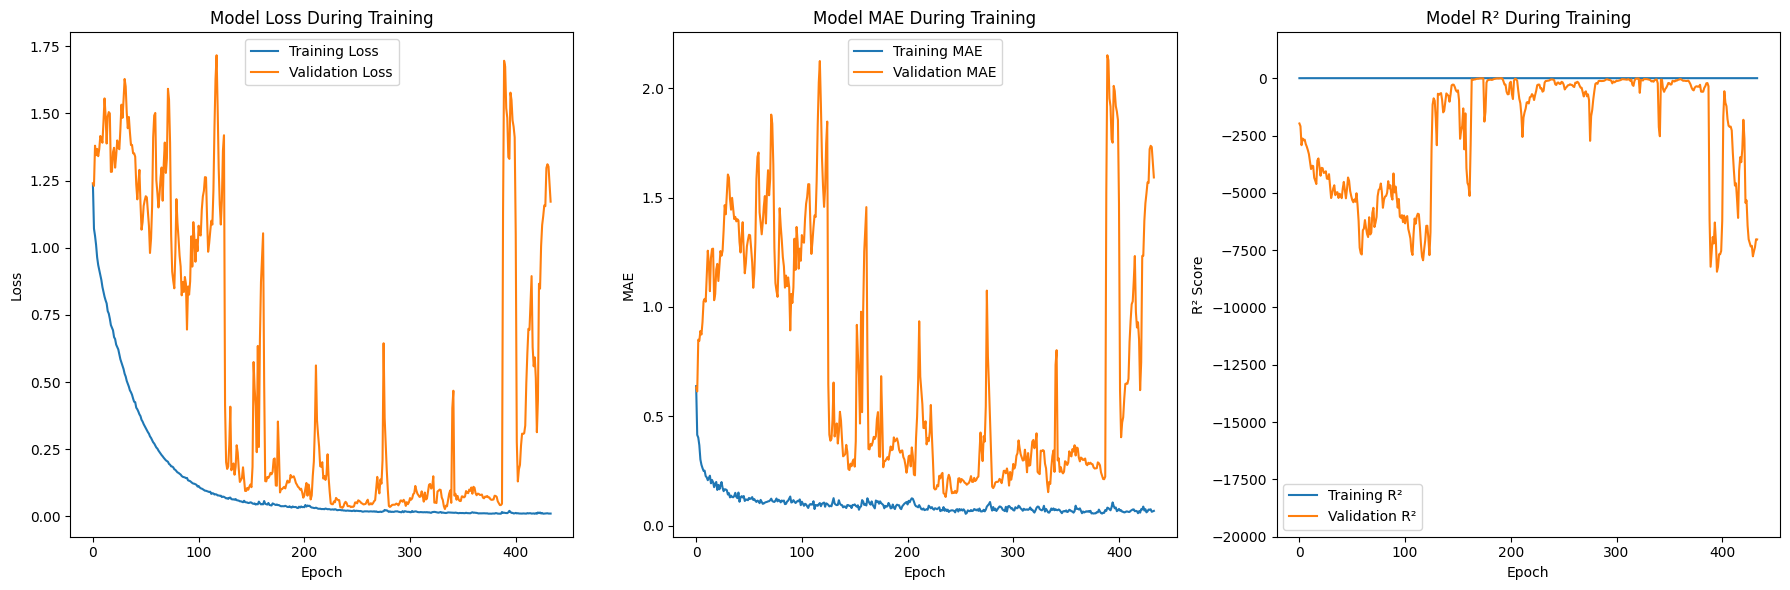

In [8]:
history_dict = history.history
print(history_dict.keys())

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Loss
axs[0].plot(history_dict['loss'], label='Training Loss')
axs[0].plot(history_dict['val_loss'], label='Validation Loss')
axs[0].set_title('Model Loss During Training')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend()

# MAE
axs[1].plot(history_dict['mae'], label='Training MAE')
axs[1].plot(history_dict['val_mae'], label='Validation MAE')
axs[1].set_title('Model MAE During Training')
axs[1].set_ylabel('MAE')
axs[1].set_xlabel('Epoch')
axs[1].legend()

# R² Score
axs[2].plot(history_dict['r2_scoree'], label='Training R²')
axs[2].plot(history_dict['val_r2_scoree'], label='Validation R²')
axs[2].set_title('Model R² During Training')
axs[2].set_ylabel('R² Score')
axs[2].set_xlabel('Epoch')
axs[2].set_ylim(-20000, 2000) 
axs[2].legend()

plt.tight_layout()
plt.show()

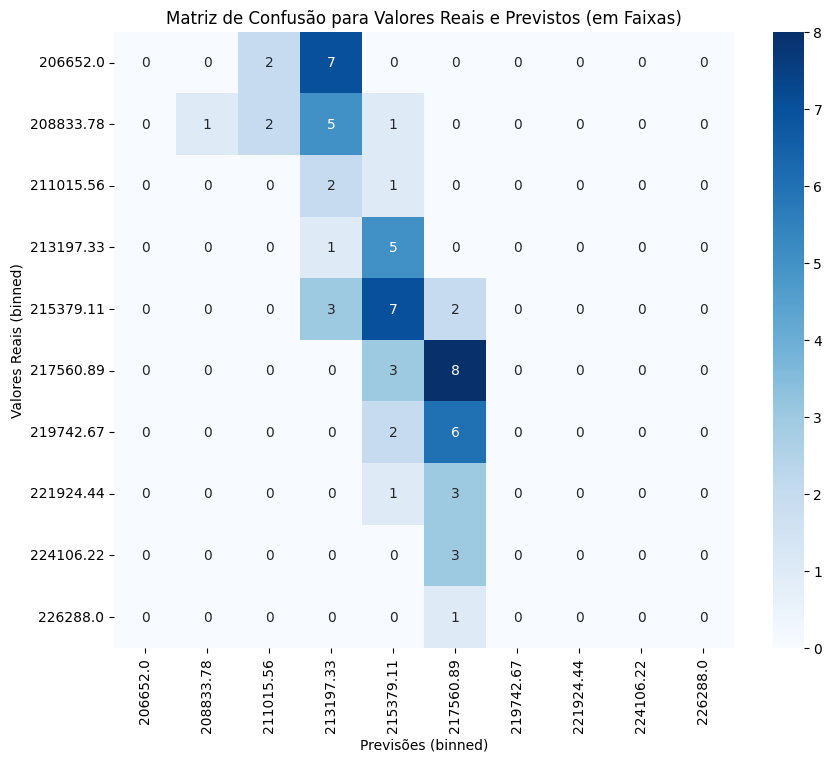

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

n_bins = 10

min_val = min(min(y_test), min(y_pred_test))
max_val = max(max(y_test), max(y_pred_test))

bins = np.linspace(min_val, max_val, n_bins)

y_test_binned = np.digitize(y_test, bins)
y_pred_binned = np.digitize(y_pred_test, bins)

conf_matrix = confusion_matrix(y_test_binned, y_pred_binned, labels=range(1, n_bins+1))

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=bins.round(2), yticklabels=bins.round(2))
plt.title('Matriz de Confusão para Valores Reais e Previstos (em Faixas)')
plt.xlabel('Previsões (binned)')
plt.ylabel('Valores Reais (binned)')
plt.show()

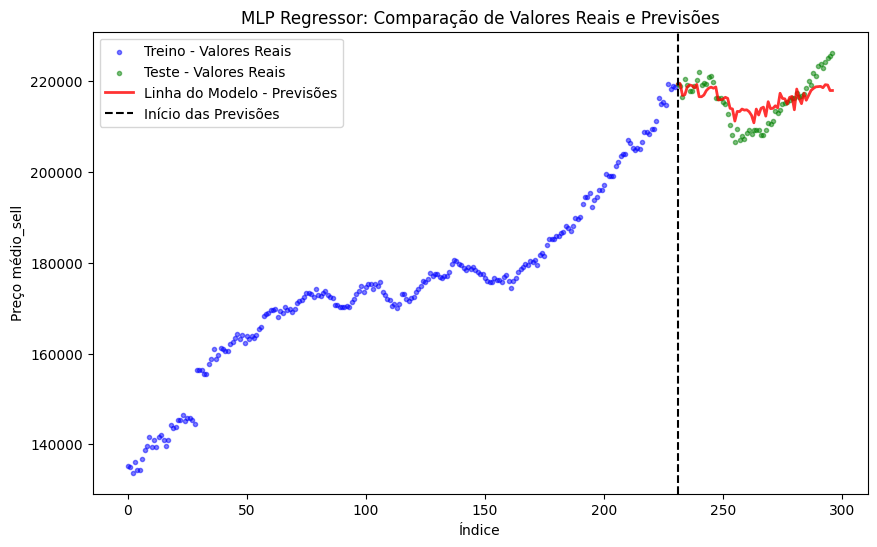

In [10]:
train_indices = range(len(y_train))
test_indices = range(len(y_train), len(y_train) + len(y_test))

plt.figure(figsize=(10, 6))
plt.scatter(train_indices, y_train, color='blue', label='Treino - Valores Reais', 
            alpha=0.5, marker='.')

plt.scatter(test_indices, y_test, color='green', label='Teste - Valores Reais', 
            alpha=0.5, marker='.')

plt.plot(test_indices, y_pred_test[:len(y_test)], color='red', 
         label='Linha do Modelo - Previsões', alpha=0.8, linewidth=2)

plt.axvline(x=len(y_train), color='black', linestyle='--', label='Início das Previsões')

plt.title('MLP Regressor: Comparação de Valores Reais e Previsões')
plt.xlabel('Índice')
plt.ylabel('Preço médio_sell')
plt.legend()

# Exibir o gráfico
# plt.grid(True)
plt.show()

In [11]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_train_scaled_df

,Avaliacoes Total,Avaliacoes Apartamentos,Avaliacoes Moradias,Capital Divida Total,Capital Divida 3M,Capital Divida 6M,Capital Divida 12M,Juros Totais,Capital Amortizado,Unemployed population,...,Date,moving_avg_price_sell,exp_moving_avg_price_sell,price_to_rent_ratio,propriedades_unicas_rent,propriedades_unicas_sell,moving_avg_price_rent,exp_moving_avg_price_rent,moving_avg_Reducao_sell,moving_avg_Reducao_rent
0,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509704,1.522042,0.607364,-1.331472,-0.125820,-0.097072,7.394434,5.608861,3.394032,2.333235
1,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.509171,-0.312236,-0.791344,-1.426681,1.412885,-0.388665,2.774553,1.719046,0.721232,0.342553
2,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508638,-2.177919,-1.525892,-1.704247,-0.467755,-0.388665,-1.888639,-0.068255,-2.397035,-1.150460
3,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.508105,-2.161097,-1.829789,-1.187599,-0.125820,-0.097072,-1.924732,-1.252871,-2.307942,-1.150460
4,0.018907,-0.058319,1.734036,-1.180380,-1.180599,-1.404461,-1.456456,0.135627,-0.281205,1.058709,...,-1.507572,-2.173442,-2.028727,-1.083630,-0.125820,-0.505303,-2.112414,-2.027032,-2.129755,-1.150460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,1.310053,1.305768,0.216755,2.242721,1.907956,1.980412,1.946246,0.795205,1.874274,-1.384726,...,1.560924,2.178019,2.193671,1.554049,1.412885,0.194522,1.092628,1.266839,-0.615168,-0.652789
227,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.566711,2.253807,2.318894,2.055961,0.216114,0.252841,1.157595,1.172592,-0.882448,-0.486899
228,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567244,2.305536,2.354204,2.061691,-1.151624,-0.446984,1.034880,1.076974,-0.615168,-0.652789
229,1.141643,1.170487,-0.541886,2.380235,1.950648,2.016076,2.022116,2.444149,1.776298,-0.993917,...,1.567777,2.382154,2.389125,2.099991,0.387082,-1.729996,0.904945,1.029165,-0.926995,-0.818679


#### Dados de validacao

In [12]:
y_valid_pred_scaled = model.predict(X_valid_scaled)
y_valid_pred = scaler_y.inverse_transform(y_valid_pred_scaled)
y_valid_real = scaler_y.inverse_transform(y_valid_scaled)

mae_valid, r2_valid, mse_valid, acc_valid = calcular_metricas(y_valid_real, 
                                                              y_valid_pred, 
                                                              "Validação")

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  


Validação: MAE: 13040.93, R²: -11.52, MSE: 182175667.98, Acurácia: 94.31%


### Results

In [13]:
results = { 
    'Conjunto': ['Treino', 'Teste', 'Validação'],
    'MAE': [mae_train, mae_test, mae_valid],
    'R²': [r2_train, r2_test, r2_valid],
    'MSE': [mse_train, mse_test, mse_valid],
    'Acurácia (%)': [acuracia_train, acuracia_test, acc_valid]
}

results_df = pd.DataFrame(results)
results_df

,Conjunto,MAE,R²,MSE,Acurácia (%)
0,Treino,751.588474,0.997399,9.195684e+05,99.569950
1,Teste,2886.864583,0.552676,1.259908e+07,98.662712
2,Validação,13040.927849,-11.516542,1.821757e+08,94.310191


In [14]:
import os
import json

def salvar_resultados_modelo(modelo_nome, localizacao,resultados_df):
    # Criar estrutura para salvar
    results_dict = resultados_df.to_dict(orient='records')
    results_dict_with_model = {
        "Modelo": modelo_nome,
        "Localização": localizacao,
        "Resultados": results_dict
    }

    # Caminho do diretório e do arquivo JSON
    directory = "modelos"
    json_filename = os.path.join(directory, 'resultadosModelos.json')

    # Criar o diretório se não existir
    if not os.path.exists(directory):
        os.makedirs(directory)

    # Verificar se o arquivo já existe
    if os.path.exists(json_filename):
        with open(json_filename, 'r') as json_file:
            existing_data = json.load(json_file)
    else:
        existing_data = []

    # Adicionar os novos resultados
    existing_data.append(results_dict_with_model)

    # Salvar de volta no arquivo JSON
    with open(json_filename, 'w') as json_file:
        json.dump(existing_data, json_file, indent=4)

    print(f"Dados salvos e adicionados ao arquivo {json_filename}")


salvar_resultados_modelo("MLP", local, results_df)

Dados salvos e adicionados ao arquivo modelos\resultadosModelos.json
